In [1]:
from __future__ import print_function
from __future__ import absolute_import
import warnings
import sys
sys.path.append('../../../../')
sys.path.append('../')
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['image.cmap'] = "viridis"
import random
random.seed(1)
print (tf.__version__)

1.3.0


In [2]:
# data files for train/val. Already preprocessed
data1 = np.load('./DATA/data_lim5000_nan.npy.zip')['data_lim5000_nan.npy'].item()
data2 = np.load('./DATA/data_lim5000_ss.npy.zip')['data_lim5000_ss'].item()
data3 = np.load('./DATA/data_lim5000_extra.npy').item()
data4 = np.load('./DATA/data_lim5000_MSA.npy').item()
#  same as above, redundant
data1_t = np.load('./DATA/data_lim5000_nan.npy.zip')['data_lim5000_nan.npy'].item()
data2_t = np.load('./DATA/data_lim5000_ss.npy.zip')['data_lim5000_ss'].item()
data3_t = np.load('./DATA/data_lim5000_extra.npy').item()
data4_t = np.load('./DATA/data_lim5000_MSA.npy').item()

In [3]:
# these contains the test sets, contains many structures, but many are repeats
puzzle = ['3OX0', '3OWZ', '3OXJ', '3OXE', '3OWZ', '3OWW', '3OXM', '3OWW', '3OWI', '3OXE',
          '3OXM', '3OX0', '3OXJ', '3OWI', '3OXB', '3OXD', '3OXD', '3OXB', '4LCK', '4TZV',
          '4TZZ', '4TZZ', '4TZZ', '4LCK', '4TZZ', '4TZP', '4TZW', '4TZP', '4TZZ', '4TZZ',
          '4TZV', '4TZW', '4TZZ', '4LCK', '4TZZ', '4TZP', '4LCK', '4TZP', '5EAQ', '5DQK',
          '5EAO', '5DH6', '5DI2', '5DH8', '5DH7', '5DI4', '4R4V', '5V3I', '4R4P', '3V7E',
          '3V7E', '4L81', '4OQU', '4P9R', '4P95', '4QLM', '4QLN', '4XWF', '4XW7', '4GXY',
          '5DDO', '5DDO', '5TPY','5T5A','5K7C','5DI4']

In [4]:
data_test = {}
data_train = {}
data_val = {}
thres_distance  = 16

In [5]:
# helper function
def make_array(str): #converts AUGC to vector. 
    temp = [0,]*len(str)
    for i in range(len(str)):
        if str[i]=='A':
            temp[i] = [1,0,0,0,0]
        elif str[i] =='U':
            temp[i] = [0,1,0,0,0]
        elif str[i] =='G':
            temp[i] = [0,0,1,0,0]
        elif str[i] =='C':
            temp[i] = [0,0,0,1,0]
        elif str[i]=='a': #lower caps means less confidence of sequence
            temp[i] = [0.5,0,0,0,0]
        elif str[i] =='u': #lower caps means less confidence of sequence
            temp[i] = [0,0.5,0,0,0]
        elif str[i] =='g': #lower caps means less confidence of sequence
            temp[i] = [0,0,0.5,0,0]
        elif str[i] =='c': #lower caps means less confidence of sequence
            temp[i] = [0,0,0,0.5,0]
        else:
            temp[i] = [0,0,0,0,1]
    return temp
def make_array2(str):
    temp = [0,]*len(str)
    for i in range(len(str)):
        if str[i]=='*':
            temp[i] = 100
        elif str[i] == 'X':
            temp[i] = 0
        else:
            temp[i] = int(str[i])*10
    return temp
def remove_diagonals(d):
    d = d.copy()
    d[0:2,0:2] = 0
    d[-2:,-2:] = 0
    for i in range(2,len(d)-2):
        d[i-1,i] =0
        d[i,i] =0
        d[i,i-1] =0
        d[i-2,i] =0
        d[i,i] =0
        d[i,i-2] =0
        d[i+1,i] =0
        d[i,i] =0
        d[i,i+1] =0
        d[i+2,i] =0
        d[i,i] =0
        d[i,i+2] =0
    return d

In [6]:
random.seed(0)

In [7]:
# making train/val/test index
data1_keys_test = [ x for x in data1_t if x[0:4].upper() in puzzle]    
data1_keys = [x for x in data1 if  len(data1[x][0]) <= 500] # the short ones get val-train split
random.shuffle(data1_keys)
data1_keys_val = ['4v9e_aa', '5lyu_a', '4qjd_b', '4pr6_b', '5fq5_a', '4cxg_a',
                  '5m0h_a', '3amt_b', '4v8m_bd', '5x2h_b', '1e8s_c', '1c9s_w',
                  '2gtt_x', '3j0o_h', '3j45_2', '3j7r_s6', '2nz4_p', '2der_c',
                  '4cxg_2', '3p22_a', '3ivn_a', '3w3s_b', '3j0p_w', '5lzs_ii',
                  '4ug0_s6', '3d2v_a', '2csx_c', '2oiu_q', '4kzd_r', '2j28_8',
                  '5t5h_e', '1ffy_t', '5aka_7', '1pn7_c', '3j46_3', '4ue4_a',
                  '1i6u_c', '3jcs_6', '1j1u_b', '3wc1_p', '3eph_e', '2qwy_a',
                  '1un6_e', '1qzc_a', '4c4q_n', '4v6u_a1', '5xh6_b', '5mmm_z',
                  '2hw8_b', '1mj1_q', '5o60_b', '2zy6_a', '5hr6_c', '4v5z_bg',
                  '2zzm_b', '1p6v_b', '4v5z_ad', '2vpl_b', '1qzw_b', '4c7o_e',
                  '2xxa_f', '2zjr_y', '5kpy_a', '4bbl_y', '1pn8_d', '1lng_b',
                  '1m5o_b', '4kr6_d', '3nkb_b', '1gax_c', '4kr6_c', '2nue_c',
                  '4v8b_ab', '5t83_a', '3p49_a', '3izd_a', '5ktj_a', '3j9w_bb',
                  '3k0j_e', '5gap_v', '3ski_a', '2om7_g', '1ysh_b', '4v8p_b3',
                  '4aob_a', '5lzs_2', '2wwb_d', '3iab_r', '4qjh_b', '4yco_d',
                  '4tue_qv', '4kr7_x', '4adx_8', '2go5_9', '4v8m_be', '1emi_b',
                  '3jb9_c', '5e54_a', '4p5j_a', '1zc8_h', '1y26_x', '1zc8_a',
                  '1hc8_c', '3iyq_a', '5it9_i', '4wj3_q', '3suh_x', '1xjr_a',
                  '4frg_b', '1zn1_c']
data1_keys_train = [x for x in data1_keys if (x not in data1_keys_val and x[0:4].upper() not in puzzle)] +\
                   [x for x in data1 if  len(data1[x][0]) > 500]

In [8]:
# this is to reduce trainset size so you can run faster
data1_keys_train= data1_keys_train[::10]

In [9]:
# below is abit hairy, preprocessing, optional #
print ('### TRAINSET processing ###')
for i in data1_keys_train:
    if len(data1[i][0]) >= 35:
        if i in data2.keys():
            try:
                temp1 = data1[i]
                a = (data1[i][2] > thres_distance)*1
                temp_resi_map = np.stack((a,),axis=2)
                d0= -1*(np.isnan(data1[i][2])-1) #non-nan values ==1 , nan =0
                d = remove_diagonals(d0)
                d = np.stack((d,) ,axis=2)
                d0= np.stack((d0,),axis=2)
                pair_wise_res = {('A','A') : 0, ('U','U') : 1, ('G','G') : 2, ('C','C') : 3,
                                 ('A','U') : 4, ('A','G') : 5, ('A','C') : 6,
                                 ('G','U') : 7, ('C','U') : 8,
                                 ('C','G') : 9}
                mat_pairres = np.zeros((len(temp1[1]),len(temp1[1]),10))
                for ii in range(0,len(temp1[1])):
                    for jj in range(ii,len(temp1[1])):
                        temp_paires = sorted((temp1[1][ii],temp1[1][jj]))
                        if tuple(temp_paires) in pair_wise_res:
                            index = pair_wise_res[tuple(temp_paires)]
                            mat_pairres[ii,jj,index] = 1
                            mat_pairres[jj,ii,index] = 1
                mat_pairres_con = np.zeros((len(temp1[1]),len(temp1[1]),10))
                for ii in range(0,len(temp1[1])):
                    for jj in range(ii,len(temp1[1])):
                        temp_paires = sorted((data4[i][1][ii].upper(),
                                              data4[i][1][jj].upper()))
                        if tuple(temp_paires) in pair_wise_res:
                            index = pair_wise_res[tuple(temp_paires)]
                            mat_pairres_con[ii,jj,index] = 1
                            mat_pairres_con[jj,ii,index] = 1
                data2[i][0] = np.reshape(data2[i][0],(len(data2[i][0]),len(data2[i][0]),1))
                temp2 = data2[i]
                temp2[0] = np.concatenate((data2[i][0],mat_pairres,mat_pairres_con),axis=2)
                temp3 = data3[i]
                temp4 = data4[i]
                tempF = np.concatenate((np.array(make_array(temp1[1])).T,np.array([temp2[1]]),temp3,(np.array(make_array(temp4[1])).T),np.array([make_array2(temp4[2])])))

                if len(temp2[0]) <=500:
                    data_train[i+'_ori'] = [tempF, temp1[0],temp1[1],temp_resi_map,d,temp2[1],temp2[0]]
                for window_tup in [(35,11),(50,13),(75,25),(100,33),(125,41),(150,50),(200,66),(300,100),(400,133),(500,167)]:
                    window, jump = window_tup[0], window_tup[1]
                    for repeat in range(0,len(data1[i][0]) - window+1,jump):
                        if np.mean(d0[repeat:repeat+window,repeat:repeat+window,:]) > 0.9: 
                            data_train[i+'_'+str(window)+'_'+str(repeat)] = [tempF[:,repeat:repeat+window],
                                                   temp1[0][repeat:repeat+window],
                                                   temp1[1][repeat:repeat+window],
                                                   temp_resi_map[repeat:repeat+window,repeat:repeat+window,:],
                                                   d[repeat:repeat+window,repeat:repeat+window,:],
                                                   temp2[1][repeat:repeat+window],
                                                   temp2[0][repeat:repeat+window,repeat:repeat+window]]
                if 2*len(data1[i][0])//3 <= 500:                    
                    window = 2*len(data1[i][0])//3
                    for repeat in (0,1*len(data1[i][0])//6,2*len(data1[i][0])//6):                  
                        data_train[i+'_'+str(window)+'_0.33'] = [tempF[:,repeat:repeat+window],
                                                           temp1[0][repeat:repeat+window],
                                                           temp1[1][repeat:repeat+window],
                                                           temp_resi_map[repeat:repeat+window,repeat:repeat+window,:],
                                                           d[repeat:repeat+window,repeat:repeat+window,:],
                                                           temp2[1][repeat:repeat+window],
                                                           temp2[0][repeat:repeat+window,repeat:repeat+window]]
                if 1*len(data1[i][0])//2 <= 500:
                    window = len(data1[i][0])//2
                    for repeat in (0,1*len(data1[i][0])//4,2*len(data1[i][0])//4):                  
                        data_train[i+'_'+str(window)+'_0.5'] = [tempF[:,repeat:repeat+window],
                                                           temp1[0][repeat:repeat+window],
                                                           temp1[1][repeat:repeat+window],
                                                           temp_resi_map[repeat:repeat+window,repeat:repeat+window,:],
                                                           d[repeat:repeat+window,repeat:repeat+window,:],
                                                           temp2[1][repeat:repeat+window],
                                                           temp2[0][repeat:repeat+window,repeat:repeat+window]]
                if 2*len(data1[i][0])//3 <= 500:
                    window = 3*len(data1[i][0])//4
                    for repeat in (0,1*len(data1[i][0])//8,2*len(data1[i][0])//8):                  
                        data_train[i+'_'+str(window)+'_0.75'] = [tempF[:,repeat:repeat+window],
                                                           temp1[0][repeat:repeat+window],
                                                           temp1[1][repeat:repeat+window],
                                                           temp_resi_map[repeat:repeat+window,repeat:repeat+window,:],
                                                           d[repeat:repeat+window,repeat:repeat+window,:],
                                                           temp2[1][repeat:repeat+window],
                                                           temp2[0][repeat:repeat+window,repeat:repeat+window]]
                        
            except ValueError:
                print ('%s had ValueError, probably some of inputs are of wrong dimention. Data thrown away ' %i)
                print (data2_t[i][0].shape),
print ('### DONE ###\n### VAlidation SET processing ###')
train_n = len(data_train)
for i in data1_keys_val:
    if len(data1[i][0]) >= 35:
        if i in data2.keys():
            try:
                temp1 = data1[i]
                a = (data1[i][2] > thres_distance)*1
                temp_resi_map = np.stack((a,),axis=2)
                d = -1*(np.isnan(data1_t[i][2])-1) #non-nan values ==1 , nan =0
                d = remove_diagonals(d) 
                d = np.stack((d,),axis=2)
                pair_wise_res = {('A','A') : 0, ('U','U') : 1, ('G','G') : 2, ('C','C') : 3,
                                 ('A','U') : 4, ('A','G') : 5, ('A','C') : 6,
                                 ('G','U') : 7, ('C','U') : 8,
                                 ('C','G') : 9}
                mat_pairres = np.zeros((len(temp1[1]),len(temp1[1]),10))
                for ii in range(0,len(temp1[1])):
                    for jj in range(ii,len(temp1[1])):
                        temp_paires = sorted((temp1[1][ii],temp1[1][jj]))
                        if tuple(temp_paires) in pair_wise_res:
                            index = pair_wise_res[tuple(temp_paires)]
                            mat_pairres[ii,jj,index] = 1
                            mat_pairres[jj,ii,index] = 1
                mat_pairres_con = np.zeros((len(temp1[1]),len(temp1[1]),10))
                for ii in range(0,len(temp1[1])):
                    for jj in range(ii,len(temp1[1])):
                        temp_paires = sorted((data4[i][1][ii].upper(),
                                              data4[i][1][jj].upper()))
                        if tuple(temp_paires) in pair_wise_res:
                            index = pair_wise_res[tuple(temp_paires)]
                            mat_pairres_con[ii,jj,index] = 1
                            mat_pairres_con[jj,ii,index] = 1
                data2[i][0] = np.reshape(data2[i][0],(len(data2[i][0]),len(data2[i][0]),1))
                temp2 = data2[i]
                temp2[0] = np.concatenate((data2[i][0],mat_pairres,mat_pairres_con),axis=2)                
                temp3 = data3[i]
                temp4 = data4[i]
                tempF = np.concatenate((np.array(make_array(temp1[1])).T,np.array([temp2[1]]),temp3,(np.array(make_array(temp4[1])).T),np.array([make_array2(temp4[2])])))
                    #         [9-features, seq, exxist_seq, cat dist_map,cat dist_map (non-zero), ss_1d, ss_2d]
                data_val[i] = [tempF, temp1[0],temp1[1],temp_resi_map,d,temp2[1],temp2[0]]
            except ValueError:
                print ('%s had ValueError, probably some of inputs are of wrong dimention. Data thrown away ' %i)
print ('### DONE ###')
print ('### BENCHMARKSET processing ###')
print ('benchmark set contains structures which were modelled in competitions, useful for benchmark') 
for i in data1_keys_test:
    if len(data1_t[i][0]) >= 35:
        if i in data2_t.keys():
            try:
                temp1 = data1_t[i]
                a = (data1_t[i][2] > thres_distance)*1
                temp_resi_map = np.stack((a,),axis=2)
                d = -1*(np.isnan(data1_t[i][2])-1) #non-nan values ==1 , nan =0
                d = remove_diagonals(d) 
                d = np.stack((d,),axis=2)
                pair_wise_res = {('A','A') : 0, ('U','U') : 1, ('G','G') : 2, ('C','C') : 3,
                                 ('A','U') : 4, ('A','G') : 5, ('A','C') : 6,
                                 ('G','U') : 7, ('C','U') : 8,
                                 ('C','G') : 9}
                mat_pairres = np.zeros((len(temp1[1]),len(temp1[1]),10))
                for ii in range(0,len(temp1[1])):
                    for jj in range(ii,len(temp1[1])):
                        temp_paires = sorted((temp1[1][ii],temp1[1][jj]))
                        if tuple(temp_paires) in pair_wise_res:
                            index = pair_wise_res[tuple(temp_paires)]
                            mat_pairres[ii,jj,index] = 1
                            mat_pairres[jj,ii,index] = 1
                mat_pairres_con = np.zeros((len(temp1[1]),len(temp1[1]),10))
                for ii in range(0,len(temp1[1])):
                    for jj in range(ii,len(temp1[1])):
                        temp_paires = sorted((data4_t[i][1][ii].upper(),
                                              data4_t[i][1][jj].upper()))
                        if tuple(temp_paires) in pair_wise_res:
                            index = pair_wise_res[tuple(temp_paires)]
                            mat_pairres_con[ii,jj,index] = 1
                            mat_pairres_con[jj,ii,index] = 1
                data2_t[i][0] = np.reshape(data2_t[i][0],(len(data2_t[i][0]),len(data2_t[i][0]),1))
                temp2 = data2_t[i]
                temp2[0] = np.concatenate((data2_t[i][0],mat_pairres,mat_pairres_con),axis=2)
                temp3 = data3_t[i]
                temp4 = data4_t[i]
                tempF = np.concatenate((np.array(make_array(temp1[1])).T,np.array([temp2[1]]),temp3,(np.array(make_array(temp4[1])).T),np.array([make_array2(temp4[2])])))
                    #         [9-features, seq, exxist_seq, cat dist_map,cat dist_map (non-zero), ss_1d, ss_2d]
                data_test[i] = [tempF, temp1[0],temp1[1],temp_resi_map,d,temp2[1],temp2[0]]
            except ValueError:
                print ('%s had ValueError, probably some of inputs are of wrong dimention. Data thrown away ' %i)

print ('### DONE ###')             
val_n = len(data_val) 
print ('training samples %s from %s PDBid, val samples %s from %s PDBid' %(train_n,len(data1_keys_train),val_n,len(data1_keys_val)))            
#np.save('data_all.npy',data)
dictt = {}
length = []
for i in data_train.keys():
	if tuple(i.split('_')[0:2]) not in dictt :
		dictt[tuple(i.split('_')[0:2])] = 1
	else :
		dictt[tuple(i.split('_')[0:2])] += 1
	length  += [len(data_train[i][1]),]
#plt.hist([dictt[x] for x in dictt],100);plt.show()
#plt.hist(length,100);plt.show()
# initialzie train data here
data2_x = []
data2_y = []
data2_y_nan = []
data2_y_ss = []
data2_name = []
classweight1 = 0.
classweight2 = 0.
classweight3 = 0.
for i in data_train:
        data2_x += [data_train[i][0],]
        data2_y += [data_train[i][3],]
        data2_y_nan += [data_train[i][-3],]
        data2_y_ss += [data_train[i][-1],]
        data2_name += [i,]
# initialzie val data here
data2_x_val = []
data2_y_val = []
data2_y_nan_val = []
data2_y_ss_val = []
data2_name_val = []       
for i in data_val:
        data2_x_val += [data_val[i][0],]
        data2_y_val += [data_val[i][3],]
        data2_y_nan_val += [data_val[i][-3],]
        data2_y_ss_val += [data_val[i][-1],]
        data2_name_val += [i,]
print (len(data2_y),'finished intitialising total number of training/val samples')
# initialzie test data here
data2_x_test = []
data2_y_test = []
data2_y_nan_test = []
data2_y_ss_test = []
data2_name_test = []       
for i in data_test:
        data2_x_test += [data_test[i][0],]
        data2_y_test += [data_test[i][3],]
        data2_y_nan_test += [data_test[i][-3],]
        data2_y_ss_test += [data_test[i][-1],]
        data2_name_test += [i,]


### TRAINSET processing ###


/home/leexa/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


### DONE ###
### VAlidation SET processing ###
### DONE ###
### BENCHMARKSET processing ###
benchmark set contains structures which were modelled in competitions, useful for benchmark


/home/leexa/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:140: RuntimeWarning: invalid value encountered in greater


### DONE ###
training samples 403 from 37 PDBid, val samples 110 from 110 PDBid
403 finished intitialising total number of training/val samples


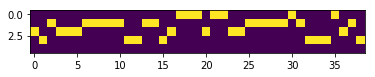

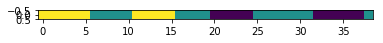

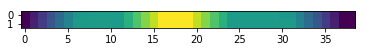

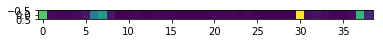

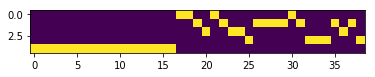

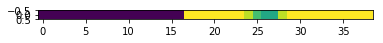

In [10]:
### SEQUENCE FEATURES EXPLORATION ####
### analyze the sequence level features
### X axis - RNA length, Y axis - features, colour = values
RNA_id = 2
plt.imshow (data2_x_val[RNA_id][:5]);plt.show() # sequence AUGC for RNA
plt.imshow (data2_x_val[RNA_id][5:6]);plt.show() # base pairs
plt.imshow (data2_x_val[RNA_id][6:8, ]);plt.show() #positional entropy, base pair probability, mean free energy structre
plt.imshow (data2_x_val[RNA_id][8:9]);plt.show() # base pairs numbering
plt.imshow (data2_x_val[RNA_id][9:-1, ]);plt.show() # sequence AUGC for consenseus sequence
plt.imshow (data2_x_val[RNA_id][-1:, ]);plt.show() # confidence of above prediction


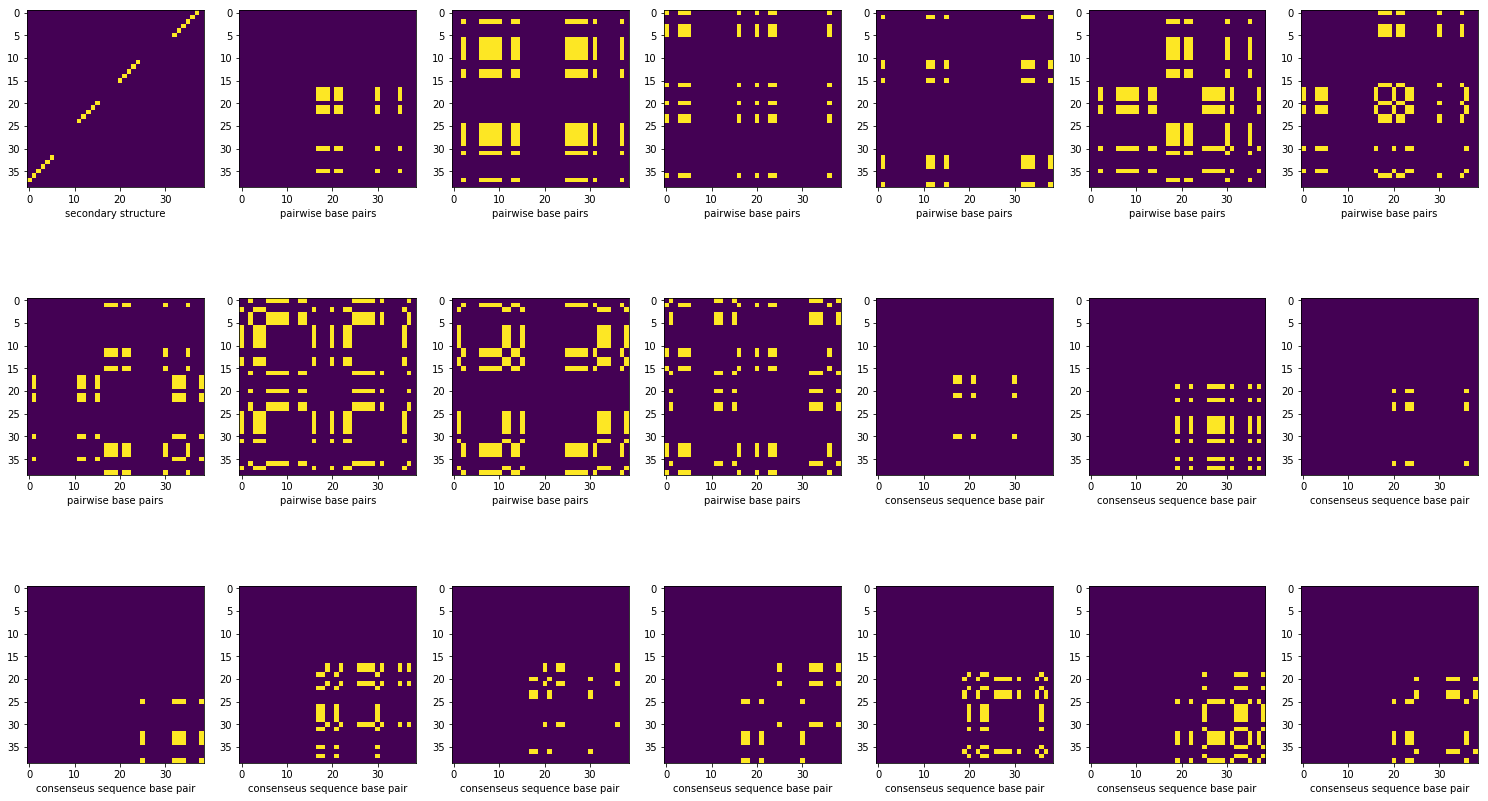

In [11]:
### PAIRWISE FEATURES EXPLORATION ####
### analyze the pairwise seqeunce  features
### X axis - RNA length, Y axis - features, colour = values
RNA_id = 2
f, ax = plt.subplots(3,7,figsize=(26,15));k=0
i=0
ax[i//7,i%7].imshow (data2_y_ss_val[RNA_id][:,:,0]);#plt.show() # secondary structure
ax[i//7,i%7].set_xlabel('secondary structure')
for i in range(1,11):
    ax[i//7,i%7].imshow (data2_y_ss_val[RNA_id][:,:,i]) #pairwise base pairs
    ax[i//7,i%7].set_xlabel('pairwise base pairs')
for i in range(11,21):
    ax[i//7,i%7].imshow (data2_y_ss_val[RNA_id][:,:,i])#consenseus sequence base pair
    ax[i//7,i%7].set_xlabel('consenseus sequence base pair')
plt.show()

In [12]:
## calculate average distances
dist =[]
for x in data1:
    for i in range(len(data1[x][-1])):
        for j in range(i+1,len(data1[x][-1])):
            dist += [data1[x][-1][i,j],]

print (dist[0])

5.829815606


In [13]:
dist[:10]

[5.8298156060033293,
 11.063443406101012,
 16.220957061776591,
 nan,
 24.250906044929536,
 26.339016876109859,
 26.958305380717089,
 27.59078864403843,
 30.083552200496534,
 34.237848253066367]

# the histogram shows peaks at ~8,12,18 using some guestimation of combined gaussians. This is why i used a cutoff of 16 for the class seperation. This is because 16 seems like the first peak.

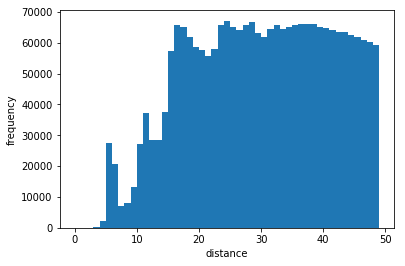

In [14]:
# the histogram of distances
plt.hist([x for x in dist if x > 0]  ,bins = range(50));
plt.xlabel('distance')
plt.ylabel('frequency')
plt.show()


# finding number of nan in distances. Distances might not be measured due to failure of experimental methods to obtain complete data

/home/leexa/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in greater_equal
  after removing the cwd from sys.path.


average of 0.0591272240682 distances are missing, std = 0.140476183928, max= 0.995116561207


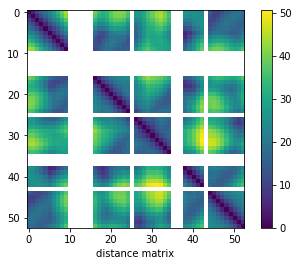

/home/leexa/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in greater_equal
  if sys.path[0] == '':


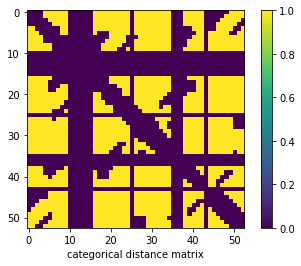

In [15]:
# the histogram of distances
per_nan = []
for x in data1:
    per_nan  += [1- np.mean(data1[x][-1] >= 0),]
print ('average of %s distances are missing, std = %s, max= %s' 
       %(np.mean(per_nan),np.std(per_nan),np.max(per_nan)))

## missing resdues shown as white bars where distance inforamtion is missing

plt.imshow(data1[data1.keys()[2]][-1]);
plt.xlabel('distance matrix');plt.colorbar();plt.show() 
plt.imshow(data1[data1.keys()[2]][-1] >= 16);
plt.xlabel('categorical distance matrix');plt.colorbar();plt.show() 

# I will maks out the missing values and the diagonals to the loss function. The diagonals are masked since they are easy to predict (always 0). Missing pixels should not be included into loss or else it will learn to predict them as 0.

/home/leexa/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater_equal
  """Entry point for launching an IPython kernel.


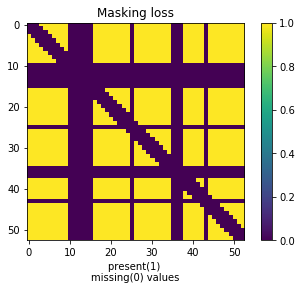

In [16]:
plt.imshow(remove_diagonals(data1[data1.keys()[2]][-1] >= 0.0));
plt.title('Masking loss')
plt.xlabel('present(1) \nmissing(0) values');plt.colorbar();plt.show() 

# Model starts here

In [17]:
# helper code
epsilon = 1e-3
def batch_normalization(x,is_training=0): #normalize each channel by its statistics. 
    mean,var = tf.nn.moments(x,[0,1,2],keep_dims=False)
    scale = tf.Variable(tf.ones([x.shape[-1]]))
    beta = tf.Variable(tf.zeros([x.shape[-1]]))
    x = tf.nn.batch_normalization(x,mean,var,beta,scale,epsilon)
    return x

def conv2d(x, W, b, strides=(1,1),relu=True,padding='SAME',name=''):
    if name != '': # Conv2D wrapper, with bias and relu activation
        x = tf.nn.conv2d(x, W, strides=[1, strides[0], strides[0], 1], padding=padding , name = name)
    else: x = tf.nn.conv2d(x, W, strides=[1, strides[0], strides[0], 1], padding=padding)
    x = tf.nn.bias_add(x, b)
    x = batch_normalization(x,phase)
    #x = tf.
    if relu is True:
        return tf.nn.relu(x)
    else:
        return x
def average_pooling2d(x,window = (2,2),strides=1,padding='same'):
    x = tf.layers.average_pooling2d(x,window,strides,padding=padding)
    #x = batch_normalization (x,phase)
    return x#tf.nn.relu(x)


In [18]:
### INPUTS ###
# tf Graph input
x = tf.placeholder(tf.float32,[1,15,None,1],name='sequence_factors')
# pairwise distances need to define
resi_map0 = tf.placeholder(tf.float32,[1,None,None,1],name='distance_mat')
# some values are na, these will be excluded from loss
above_zero = tf.placeholder(tf.float32,[1,None,None,1],name='above_zero')
above_zero = tf.cast(above_zero,dtype=tf.float32) #TF to float
# if tf.is_nan, use convert to 0, else use original values
resi_map = tf.where(tf.is_nan(resi_map0),above_zero,resi_map0,name='sequence')
# ss_2d
ss_2d = tf.placeholder(tf.float32,[1,None,None,21],name='ss_2d')
#resi_map = tf.reshape(resi_map, shape=[1, -1, -1, 1])
#x = tf.reshape(x, shape=[1, -1, 4, 1])
rate = tf.placeholder(tf.float32,name='rate') #dropout (keep probability)


In [19]:
### DEFINING NUMBER OF WEIGHTS ###
window = 5
num1 = 64/4
num2 = 96/4
num3 = 192/4
num4 = 192/4
num5 = 224/4
num6 = 0/4
num7 = 0/4
# Store layers weight & bias
weights = {
    # 1D inception layer
    '1_wc1aa': tf.Variable(tf.random_normal([15, 1, 1, num1])),
    '1_wc1ab': tf.Variable(tf.random_normal([1, window, num1, num1])),
    '1_wc1ac': tf.Variable(tf.random_normal([1, window, num1, num1])),
    '1_wc1ba': tf.Variable(tf.random_normal([15, 1, 1, num1])),
    '1_wc1bb': tf.Variable(tf.random_normal([1, window, num1, num1])),
    '1_wc1c': tf.Variable(tf.random_normal([15, 1, 1, num1])),
    '1_wc1d': tf.Variable(tf.random_normal([15, 1, 1, num1])),
    # 1D inception layer
    '2_wc1aa': tf.Variable(tf.random_normal([1, 1, num1*4, num2])),
    '2_wc1ab': tf.Variable(tf.random_normal([1, window, num2, num2])),
    '2_wc1ac': tf.Variable(tf.random_normal([1, window, num2, num2])),
    '2_wc1ba': tf.Variable(tf.random_normal([1, 1, num1*4, num2])),
    '2_wc1bb': tf.Variable(tf.random_normal([1, window, num2, num2])),
    '2_wc1c': tf.Variable(tf.random_normal([1, 1, num1*4,num2])),
    '2_wc1d': tf.Variable(tf.random_normal([1, 1, num1*4, num2])),
    '2_SS' : tf.Variable(tf.random_normal([1,1,21,43])),
    
    # 2D inception layer output 96 layer
    '3_wc1aa': tf.Variable(tf.random_normal([1, 1, num2*4+64, num3])),
    '3_wc1ab': tf.Variable(tf.random_normal([window, 1, num3, num3])),
    '3_wc1ac': tf.Variable(tf.random_normal([1, window, num3, num3])),
    '3_wc1ba': tf.Variable(tf.random_normal([1, 1, num2*4+64, num3])),
    '3_wc1bb': tf.Variable(tf.random_normal([3, 3, num3, num3])),
    '3_wc1c': tf.Variable(tf.random_normal([1, 1, num2*4+64, num3])),
    '3_wc1d': tf.Variable(tf.random_normal([1, 1, num2*4+64, num3])),


    '4_wc1aa': tf.Variable(tf.random_normal([1, 1, num3*4, num4])),
    '4_wc1ab': tf.Variable(tf.random_normal([1, window, num4, num4])),
    '4_wc1ac': tf.Variable(tf.random_normal([window, 1, num4, num4])),
    '4_wc1ba': tf.Variable(tf.random_normal([1, 1, num3*4, num4])),
    '4_wc1bb': tf.Variable(tf.random_normal([3, 3, num4, num4])),
    '4_wc1c': tf.Variable(tf.random_normal([1, 1, num3*4, num4])),
    '4_wc1d': tf.Variable(tf.random_normal([1, 1, num3*4, num4])),

    '5_wc1aa': tf.Variable(tf.random_normal([1, 1, num4*4, num5])),
    '5_wc1ab': tf.Variable(tf.random_normal([window, 1, num5, num5])),
    '5_wc1ac': tf.Variable(tf.random_normal([1, window, num5, num5])),
    '5_wc1ba': tf.Variable(tf.random_normal([1, 1, num4*4, num5])),
    '5_wc1bb': tf.Variable(tf.random_normal([3, 3, num5, num5])),
    '5_wc1c': tf.Variable(tf.random_normal([1, 1, num4*4, num5])),
    '5_wc1d': tf.Variable(tf.random_normal([1, 1, num4*4, num5])),

    '6_wc1aa': tf.Variable(tf.random_normal([1, 1, num5*4, num6])),
    '6_wc1ab': tf.Variable(tf.random_normal([1, window, num6, num6])),
    '6_wc1ac': tf.Variable(tf.random_normal([window, 1, num6, num6])),
    '6_wc1ba': tf.Variable(tf.random_normal([1, 1, num5*4, num6])),
    '6_wc1bb': tf.Variable(tf.random_normal([3, 3, num6, num6])),
    '6_wc1c': tf.Variable(tf.random_normal([1, 1, num5*4, num6])),
    '6_wc1d': tf.Variable(tf.random_normal([1, 1, num5*4, num6])),

    '7_wc1aa': tf.Variable(tf.random_normal([1, 1, num6*4, num7])),
    '7_wc1ab': tf.Variable(tf.random_normal([window, 1, num7, num7])),
    '7_wc1ac': tf.Variable(tf.random_normal([1, window, num7, num7])),
    '7_wc1ba': tf.Variable(tf.random_normal([1, 1, num6*4, num7])),
    '7_wc1bb': tf.Variable(tf.random_normal([window/2, window/2, num7, num7])),
    '7_wc1c': tf.Variable(tf.random_normal([1, 1, num6*4, num7])),
    '7_wc1d': tf.Variable(tf.random_normal([1, 1, num6*4, num7])),

    '9_out2': tf.Variable(tf.random_normal([5,5,num5*4, 1]))   
}

biases = {
    '1_bc1aa': tf.Variable(tf.random_normal([num1])),
    '1_bc1ab': tf.Variable(tf.random_normal([num1])),
    '1_bc1ac': tf.Variable(tf.random_normal([num1])),
    '1_bc1ba': tf.Variable(tf.random_normal([num1])),
    '1_bc1bb': tf.Variable(tf.random_normal([num1])),
    '1_bc1c': tf.Variable(tf.random_normal([num1])),
    '1_bc1d': tf.Variable(tf.random_normal([num1])),

    '2_bc1aa': tf.Variable(tf.random_normal([num2])),
    '2_bc1ab': tf.Variable(tf.random_normal([num2])),
    '2_bc1ac': tf.Variable(tf.random_normal([num2])),
    '2_bc1ba': tf.Variable(tf.random_normal([num2])),
    '2_bc1bb': tf.Variable(tf.random_normal([num2])),
    '2_bc1c': tf.Variable(tf.random_normal([num2])),
    '2_bc1d': tf.Variable(tf.random_normal([num2])),
    '2_SS' : tf.Variable(tf.random_normal([43])),

    '3_bc1aa': tf.Variable(tf.random_normal([num3])),
    '3_bc1ab': tf.Variable(tf.random_normal([num3])),
    '3_bc1ac': tf.Variable(tf.random_normal([num3])),
    '3_bc1ba': tf.Variable(tf.random_normal([num3])),
    '3_bc1bb': tf.Variable(tf.random_normal([num3])),
    '3_bc1c': tf.Variable(tf.random_normal([num3])),
    '3_bc1d': tf.Variable(tf.random_normal([num3])),

    '4_bc1aa': tf.Variable(tf.random_normal([num4])),
    '4_bc1ab': tf.Variable(tf.random_normal([num4])),
    '4_bc1ac': tf.Variable(tf.random_normal([num4])),
    '4_bc1ba': tf.Variable(tf.random_normal([num4])),
    '4_bc1bb': tf.Variable(tf.random_normal([num4])),
    '4_bc1c': tf.Variable(tf.random_normal([num4])),
    '4_bc1d': tf.Variable(tf.random_normal([num4])),

    '5_bc1aa': tf.Variable(tf.random_normal([num5])),
    '5_bc1ab': tf.Variable(tf.random_normal([num5])),
    '5_bc1ac': tf.Variable(tf.random_normal([num5])),
    '5_bc1ba': tf.Variable(tf.random_normal([num5])),
    '5_bc1bb': tf.Variable(tf.random_normal([num5])),
    '5_bc1c': tf.Variable(tf.random_normal([num5])),
    '5_bc1d': tf.Variable(tf.random_normal([num5])),

    '6_bc1aa': tf.Variable(tf.random_normal([num6])),
    '6_bc1ab': tf.Variable(tf.random_normal([num6])),
    '6_bc1ac': tf.Variable(tf.random_normal([num6])),
    '6_bc1ba': tf.Variable(tf.random_normal([num6])),
    '6_bc1bb': tf.Variable(tf.random_normal([num6])),
    '6_bc1c': tf.Variable(tf.random_normal([num6])),
    '6_bc1d': tf.Variable(tf.random_normal([num6])),

    '7_bc1aa': tf.Variable(tf.random_normal([num7])),
    '7_bc1ab': tf.Variable(tf.random_normal([num7])),
    '7_bc1ac': tf.Variable(tf.random_normal([num7])),
    '7_bc1ba': tf.Variable(tf.random_normal([num7])),
    '7_bc1bb': tf.Variable(tf.random_normal([num7])),
    '7_bc1c': tf.Variable(tf.random_normal([num7])),
    '7_bc1d': tf.Variable(tf.random_normal([num7])),
    
    '9_out2': tf.Variable(tf.random_normal([1]))
}
print ('number of weights')
total_parameters = 0
for variable in sorted(weights):
    # shape is an array of tf.Dimension
    shape = weights[variable].get_shape()
    variable_parameters = 1
    for dim in shape:
        variable_parameters *= dim.value
    print(variable,variable_parameters)
    total_parameters += variable_parameters
print(total_parameters, ':total parameters')


number of weights
1_wc1aa 240
1_wc1ab 1280
1_wc1ac 1280
1_wc1ba 240
1_wc1bb 1280
1_wc1c 240
1_wc1d 240
2_SS 903
2_wc1aa 1536
2_wc1ab 2880
2_wc1ac 2880
2_wc1ba 1536
2_wc1bb 2880
2_wc1c 1536
2_wc1d 1536
3_wc1aa 7680
3_wc1ab 11520
3_wc1ac 11520
3_wc1ba 7680
3_wc1bb 20736
3_wc1c 7680
3_wc1d 7680
4_wc1aa 9216
4_wc1ab 11520
4_wc1ac 11520
4_wc1ba 9216
4_wc1bb 20736
4_wc1c 9216
4_wc1d 9216
5_wc1aa 10752
5_wc1ab 15680
5_wc1ac 15680
5_wc1ba 10752
5_wc1bb 28224
5_wc1c 10752
5_wc1d 10752
6_wc1aa 0
6_wc1ab 0
6_wc1ac 0
6_wc1ba 0
6_wc1bb 0
6_wc1c 0
6_wc1d 0
7_wc1aa 0
7_wc1ab 0
7_wc1ac 0
7_wc1ba 0
7_wc1bb 0
7_wc1c 0
7_wc1d 0
9_out2 5600
283815 :total parameters


In [20]:
### CLEAR UP RAM ### 
import gc
del data1,data2,data3,data4
del data1_t,data2_t,data3_t,data4_t
del data_val,data_train
gc.collect()


15896

In [21]:
### MODEL ###
# construct model
# 1D first inception layer
phase = tf.placeholder(tf.bool, name='phase')
dropout = tf.placeholder(tf.float32,name='dropout')
norm_x = x#batch_normalization(x,phase)
conv1aa = conv2d(norm_x,weights['1_wc1aa'],biases['1_bc1aa'],padding='VALID')
conv1ab = conv2d(conv1aa,weights['1_wc1ab'],biases['1_bc1ab'],name='conv1ab')
conv1ac = conv2d(conv1ab,weights['1_wc1ac'],biases['1_bc1ac'],name='conv1ac')
conv1ba = conv2d(norm_x,weights['1_wc1ba'],biases['1_bc1ba'],padding='VALID')
conv1bb = conv2d(conv1ba,weights['1_wc1bb'],biases['1_bc1bb'],name='conv1bb')
conv1ca = conv2d(norm_x,weights['1_wc1c'],biases['1_bc1c'],padding='VALID')
conv1cb = average_pooling2d(conv1ca,(1,2),1,padding='same')
conv1da = conv2d(norm_x,weights['1_wc1d'],biases['1_bc1d'],padding='VALID')
conv1 = tf.concat([conv1ac,conv1bb,conv1cb,conv1da],3)
conv1 = tf.layers.dropout(conv1,rate=dropout,name='drop1',training=False)

# 1d second inception layer
conv2aa = conv2d(conv1,weights['2_wc1aa'],biases['2_bc1aa'],relu=False) #gives linear combination between channels
conv2ab = conv2d(conv2aa,weights['2_wc1ab'],biases['2_bc1ab'])
conv2ac = conv2d(conv2ab,weights['2_wc1ac'],biases['2_bc1ac'])
conv2ba = conv2d(conv1,weights['2_wc1ba'],biases['2_bc1ba'],relu=False) #gives linear combination between channels
conv2bb = conv2d(conv2ba,weights['2_wc1bb'],biases['2_bc1bb'])
conv2ca = average_pooling2d(conv1,(1,2),1,padding='same')
conv2cb = conv2d(conv1,weights['2_wc1c'],biases['2_bc1c'])
conv2da = conv2d(conv1,weights['2_wc1d'],biases['2_bc1d']) #not to over helper function with name, changed variable from conv2d to conv2da
conv2 = tf.concat([conv2ac,conv2bb,conv2cb,conv2da],3)
conv2 = tf.layers.dropout(conv2,rate=dropout,training=False)

# linear combination of 2DSS
ss_2d_2 = conv2d(ss_2d,weights['2_SS'],biases['2_SS'],padding='VALID',relu=True)
final = []
for i in range(0,0):
    mat_x = conv2[:,:,:,i]
    final += [tf.matmul(mat_x,mat_x,transpose_a=True),]
    #final += tf.reshape(final[i],(-1,100,100,1))
#final +=  [ss_2d,]
for i in range(0,num2*4): #reconstruction of image from SVD
    diag  = tf.diag(conv2[:,0,:,i])[:,:,0,:] #batch size must be 1 because of here
    ud = tf.matmul(diag[:,:,:],conv2[:,0,:,:])
    svd = tf.matmul(ud, tf.transpose(conv2[:,0,:,:],(0,2,1))) 
    final += [svd,]

y = tf.stack(final,axis=3)
y1 = tf.concat([y,ss_2d,ss_2d_2],axis = 3)
y2 = batch_normalization(y1,phase)


# 2d first inception layer
conv3aa = conv2d(y2,weights['3_wc1aa'],biases['3_bc1aa'],relu=False) #gives linear combination between channels
# 15 x 1 followed by 1 x 15 convolution == 15 x 15 convolution
conv3ab = conv2d(conv3aa,weights['3_wc1ab'],biases['3_bc1ab'],relu=False) 
conv3ac = conv2d(conv3ab,weights['3_wc1ac'],biases['3_bc1ac'],relu=False)
conv3ba = conv2d(y2,weights['3_wc1ba'],biases['3_bc1ba'],relu=False) #gives linear combination between channels
conv3bb = conv2d(conv3ba,weights['3_wc1bb'],biases['3_bc1bb'])
conv3ca = average_pooling2d(y2,(2,2),1,padding='same')
conv3cb = conv2d(y2,weights['3_wc1c'],biases['3_bc1c'])
conv3d = conv2d(y2,weights['3_wc1d'],biases['3_bc1d'])
conv3 = tf.concat([conv3ac,conv3bb,conv3cb,conv3d],3)
conv3 = tf.layers.dropout(conv3,rate=dropout,training=True)
# 2d second inception layer
conv4aa = conv2d(conv3,weights['4_wc1aa'],biases['4_bc1aa'],relu=False) #gives linear combination between channels
# 15 x 1 followed by 1 x 15 convolution == 15 x 15 convolution
conv4ab = conv2d(conv4aa,weights['4_wc1ab'],biases['4_bc1ab'],relu=False)
conv4ac = conv2d(conv4ab,weights['4_wc1ac'],biases['4_bc1ac'],relu=False)
conv4ba = conv2d(conv3,weights['4_wc1ba'],biases['4_bc1ba'],relu=False) #gives linear combination between channels
conv4bb = conv2d(conv4ba,weights['4_wc1bb'],biases['4_bc1bb'])
conv4ca = average_pooling2d(conv3,(2,2),1,padding='same')
conv4cb = conv2d(conv3,weights['4_wc1c'],biases['4_bc1c'])
conv4d = conv2d(conv3,weights['4_wc1d'],biases['4_bc1d'])
conv4 = tf.concat([conv4ac,conv4bb,conv4cb,conv4d],3)
conv4 = tf.layers.dropout(conv4,rate=dropout,training=True)
### 2d third inception layer
conv5aa = conv2d(conv4,weights['5_wc1aa'],biases['5_bc1aa'])
conv5ab = conv2d(conv5aa,weights['5_wc1ab'],biases['5_bc1ab'])
conv5ac = conv2d(conv5ab,weights['5_wc1ac'],biases['5_bc1ac'])
conv5ba = conv2d(conv4,weights['5_wc1ba'],biases['5_bc1ba'])
conv5bb = conv2d(conv5ba,weights['5_wc1bb'],biases['5_bc1bb'])
conv5ca = average_pooling2d(conv4,(2,2),1,padding='same')
conv5cb = conv2d(conv4,weights['5_wc1c'],biases['5_bc1c'])
conv5d = conv2d(conv4,weights['5_wc1d'],biases['5_bc1d'])
conv5 = tf.concat([conv5ac,conv5bb,conv5cb,conv5d],3)
conv5 = tf.layers.dropout(conv5,rate=dropout,training=True)

out = conv2d(conv5,weights['9_out2'],biases['9_out2'],relu=False)
out_softmax = tf.nn.sigmoid(out)


In [22]:
### Define loss and optimizer ###

log_loss =tf.nn.sigmoid_cross_entropy_with_logits(logits = out, labels = resi_map )
cost =  tf.reduce_mean(tf.multiply(log_loss,above_zero)) # this is masking the nan and diagonals in the loss
learning_rate = tf.Variable(0,dtype= np.float32)
update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(update_ops):
    extra_optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate,momentum=0.5).minimize(cost)
def accuracy(mat_model,answer):
    mat_model = np.reshape(mat_model,(mat_model.shape[1],mat_model.shape[1]))
    answer = np.reshape(answer,(answer.shape[1],answer.shape[1]))
    score = [[0],[0],[0]]
    for i in range(0,answer.shape[1]):
        if np.sum(answer[i,:]) != 0:
            for j in range(i+1,answer.shape[1]):
                if np.sum(answer[j,:]) != 0:
                    if answer[i,j] == mat_model[i,j]:
                        score[answer[i,j]] += [1,]
                    else:
                        score[answer[i,j]] += [0,]
    return np.mean([np.mean(score[0]),np.mean(score[1])])

In [23]:
### LOAD LASTEST CHECKPOINT ###
import os
saver = tf.train.Saver()
# Initializing the variables
init = tf.global_variables_initializer();sess = tf.Session();sess.run(init)
saved_files = [xxx[:-5] for xxx in os.listdir('.') if (xxx.startswith('model') and xxx.endswith('.ckpt.meta'))]
next_epoch = 0
if len(saved_files) >= 1:
    last_file = sorted(saved_files,key=lambda x : int(x.split('_')[-2]))[-1]
    next_epoch = int(last_file.split('_')[-2])
    print ('starting from :' ,last_file)
    saver.restore(sess,'./'+last_file)# Training cycle

starting from : model300_reweigh_loss_245_70.ckpt
INFO:tensorflow:Restoring parameters from ./model300_reweigh_loss_245_70.ckpt


test balanced accuracy 0.801979566128, 


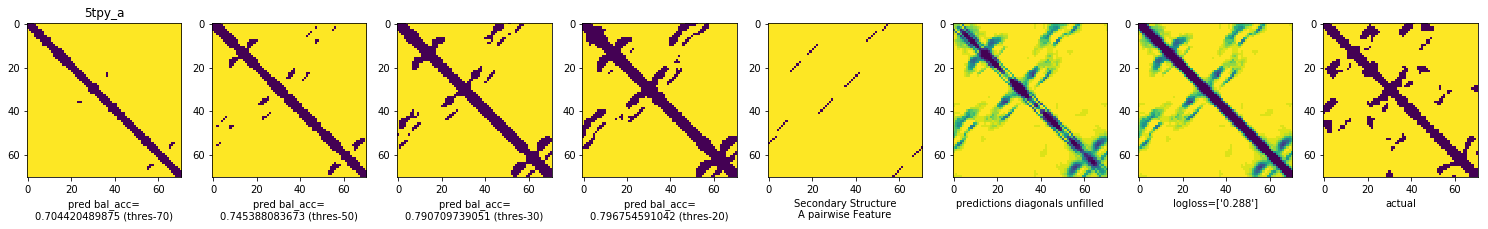

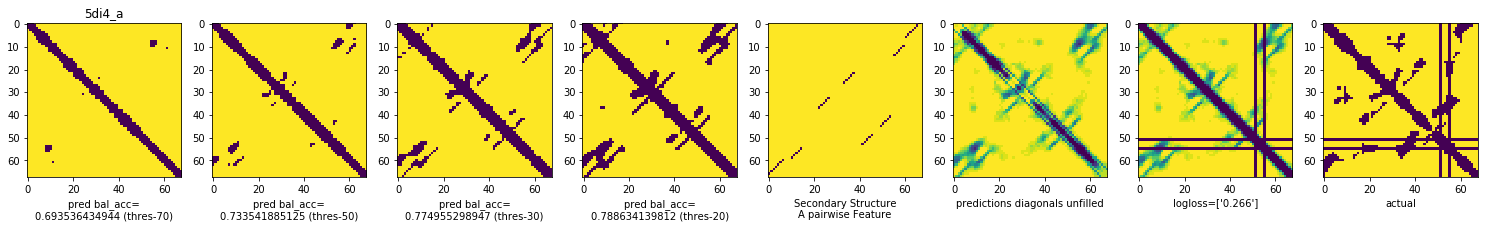

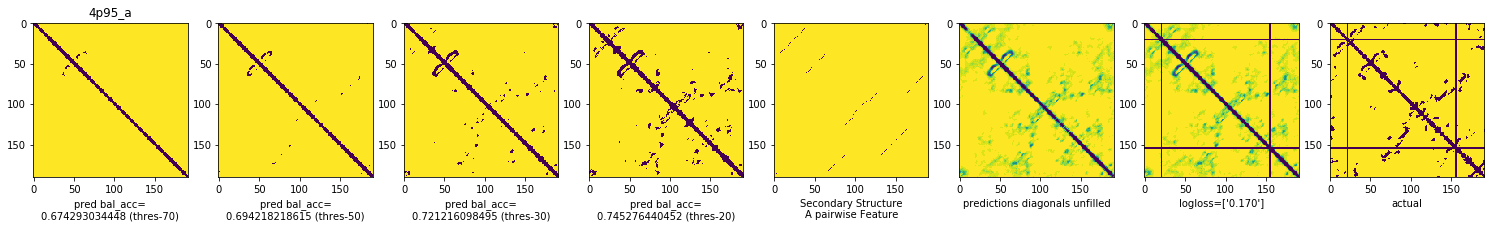

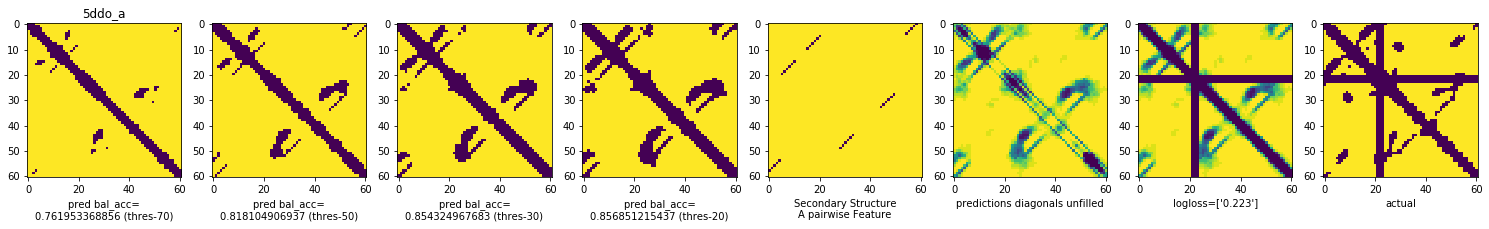

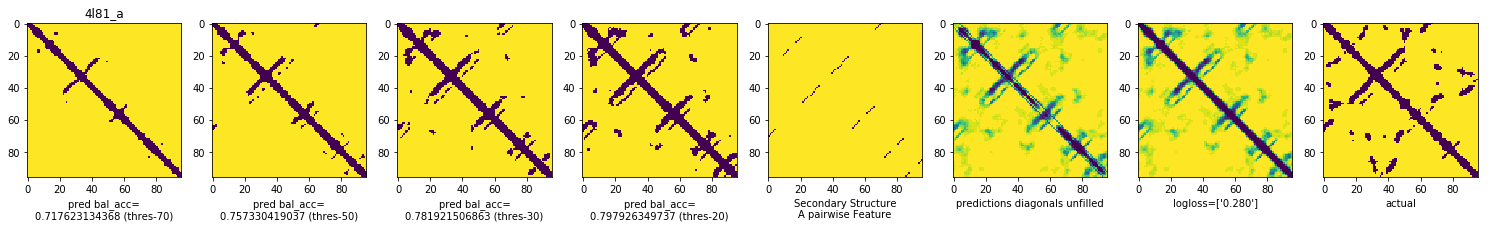

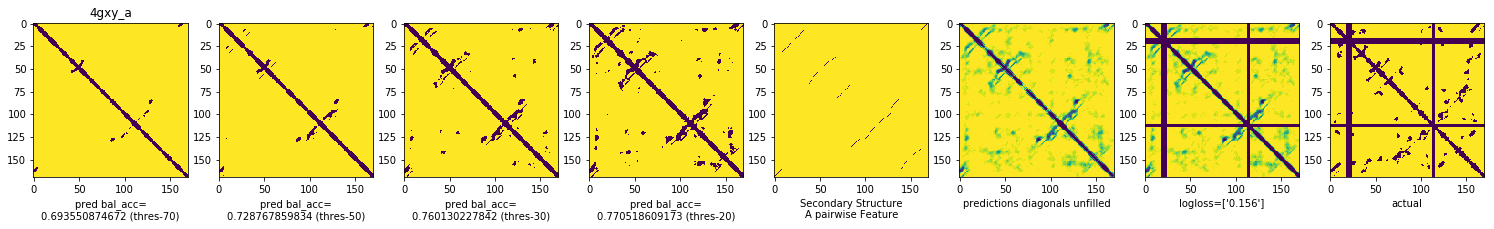

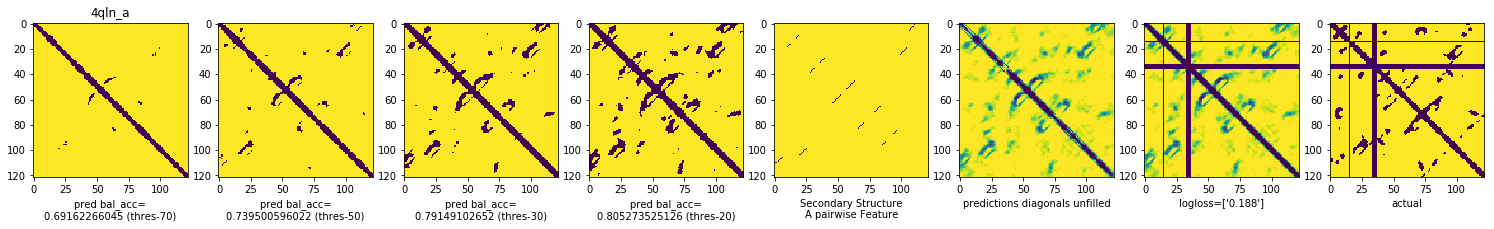

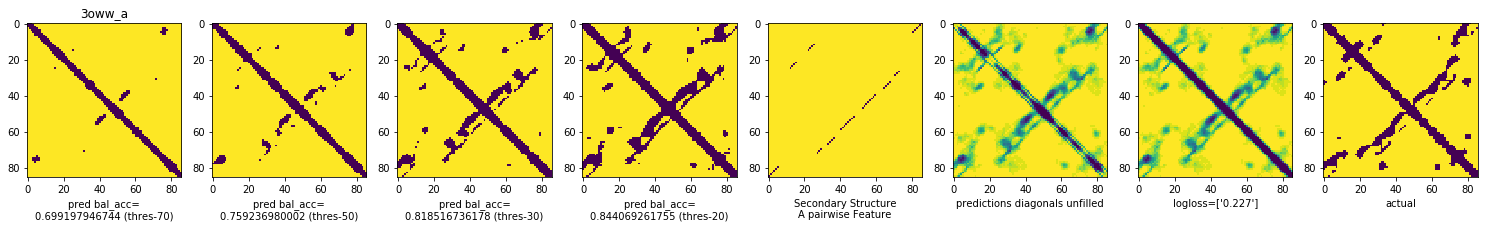

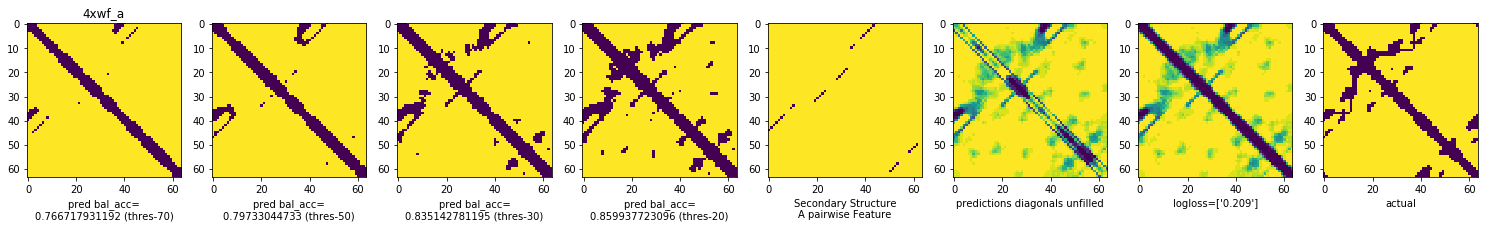

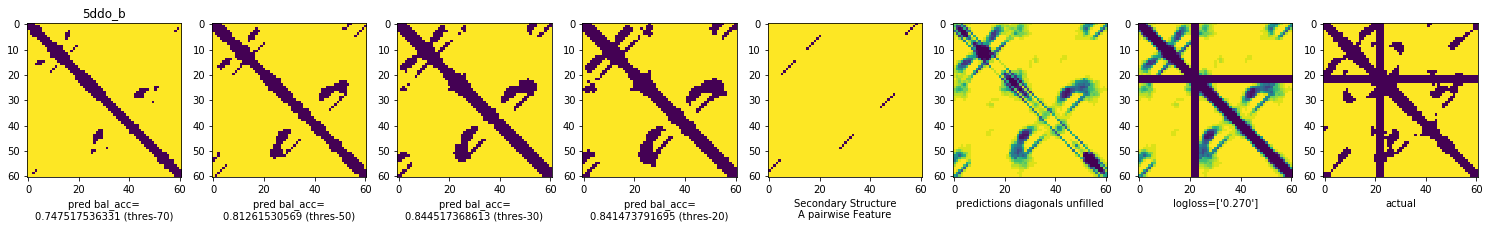

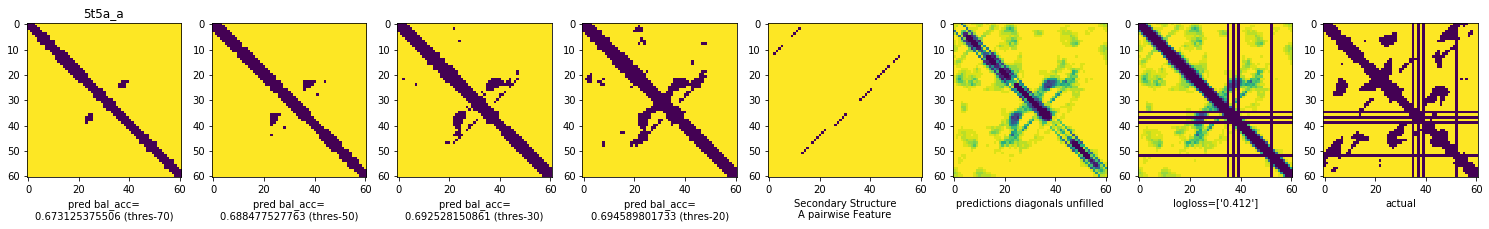

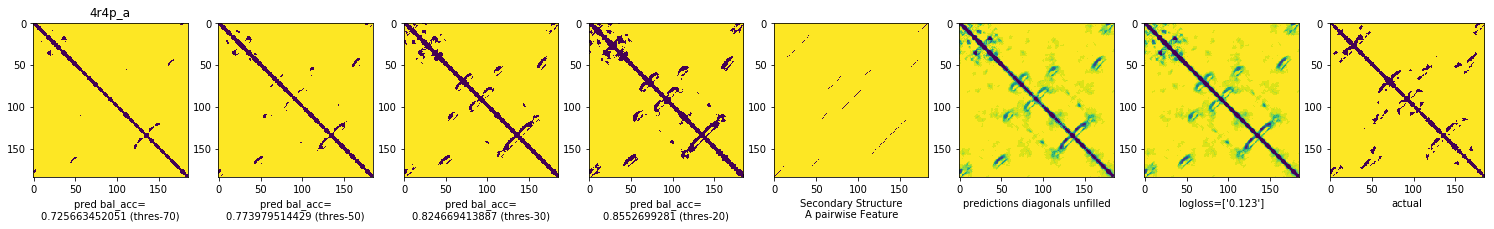

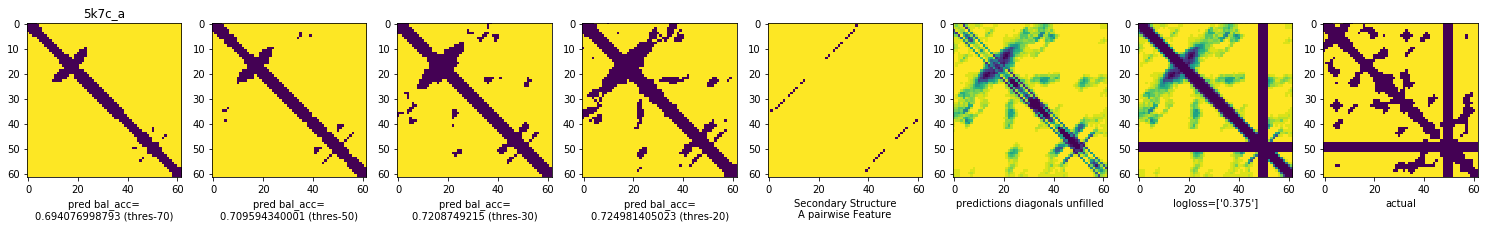

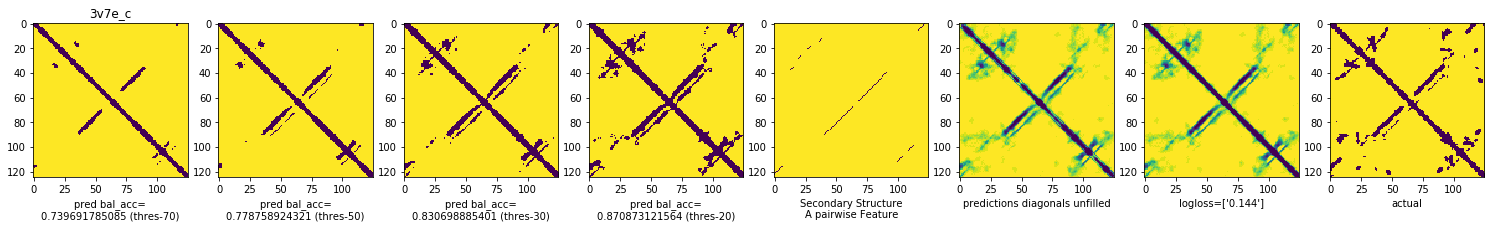

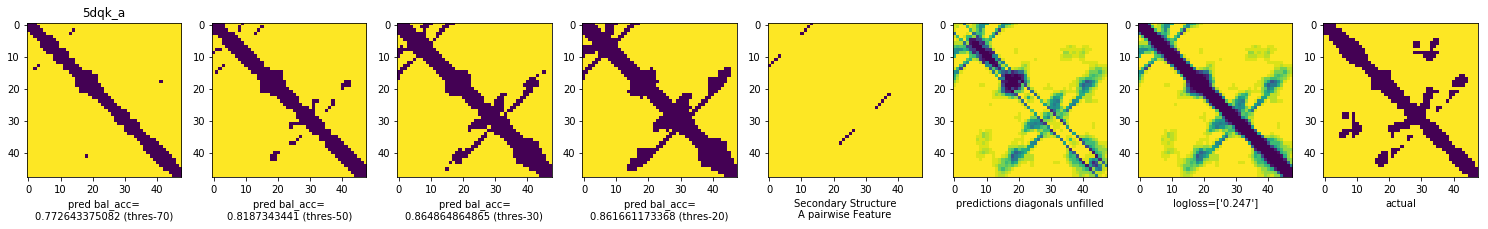

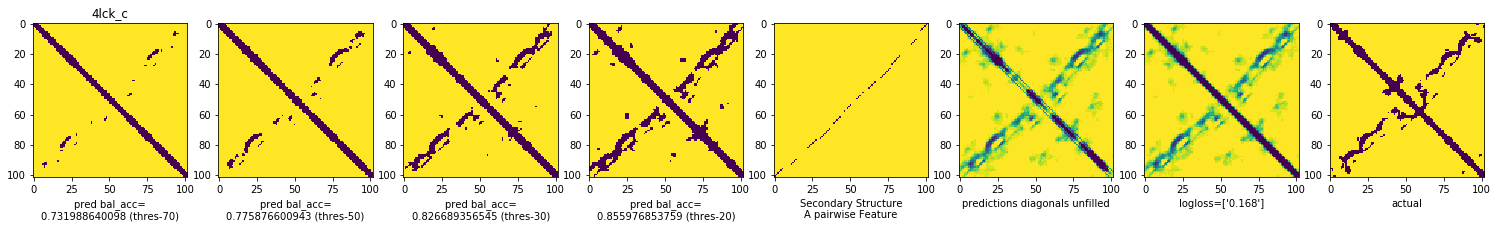

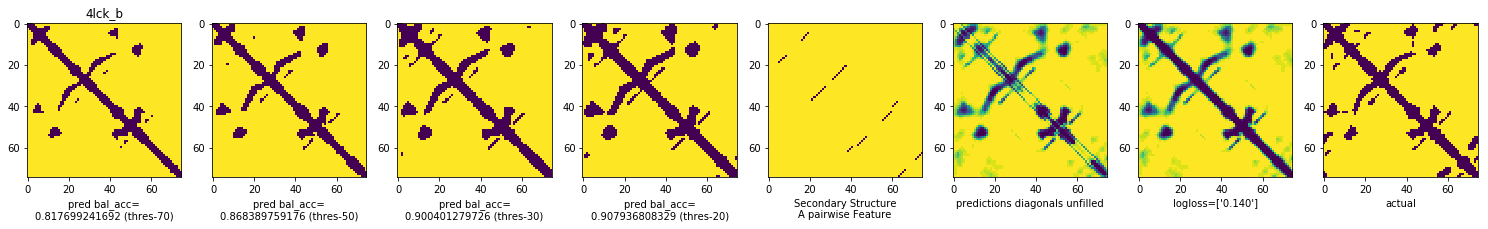

In [51]:
### PLOT TEST RESULTS###
lr=0
k= 0 
test_acc = []
for i in range(len(data2_x_test)):
    batch_x, batch_y = np.array([[data2_x_test[i],],]),np.array([data2_y_test[i],])
    batch_y_nan,batch_y_ss = np.array([data2_y_nan_test[i]]),np.array([data2_y_ss_test[i]])
    batch_x = np.swapaxes(np.swapaxes(batch_x,1,3),1,2)
    pred = sess.run( out_softmax, feed_dict={x: batch_x,resi_map0: batch_y,
                                                             above_zero : batch_y_nan, ss_2d : batch_y_ss,
                                                                phase : False, learning_rate : lr, dropout : 0})
    cost_i  = sess.run( cost, feed_dict={x: batch_x,resi_map0: batch_y,
                                                         above_zero : batch_y_nan, ss_2d : batch_y_ss,
                                                         phase : False, learning_rate : lr, dropout : 0})
    temp_pred = pred[k]+np.transpose(pred[k],(1,0,2))
    f, ax = plt.subplots(1,8,figsize=(26,5));k=0
    temp_pred = pred[k]+np.transpose(pred[k],(1,0,2))
    ax[-3].imshow(temp_pred[:,:,0]*200//20)
    temp_pred2 = (temp_pred[:,:,0])*remove_diagonals(1+np.zeros((batch_y_nan.shape[1],batch_y_nan.shape[2])))
    temp_pred[:,:,0] = (temp_pred[:,:,0])*batch_y_nan[0,:,:,0]
    ax[0].imshow(temp_pred2[:,:]>=0.6)
    ax[1].imshow(temp_pred2[:,:]>=1.0)
    ax[2].imshow(temp_pred2[:,:]>=1.4)
    ax[3].imshow(temp_pred2[:,:]>=1.6)
    ax[4].imshow(1-batch_y_ss[0,:,:,0])
    ax[4].set_xlabel('Secondary Structure\nA pairwise Feature')
    ax[-2].imshow(temp_pred[:,:,0] *200//20)
    ax[-1].imshow(batch_y[k,:,:,0]>=1)
    ax[0].set_xlabel('pred bal_acc=\n%s (thres-70)'%accuracy(temp_pred[:,:,0]>=.6,batch_y[k,:,:,0]>=1))
    ax[1].set_xlabel('pred bal_acc=\n%s (thres-50)'%accuracy(temp_pred[:,:,0]>=1.0,batch_y[k,:,:,0]>=1))
    ax[2].set_xlabel('pred bal_acc=\n%s (thres-30)'%accuracy(temp_pred[:,:,0]>=1.4,batch_y[k,:,:,0]>=1))
    ax[3].set_xlabel('pred bal_acc=\n%s (thres-20)'%accuracy(temp_pred[:,:,0]>=1.6,batch_y[k,:,:,0]>=1))
    ax[-2].set_xlabel('logloss=%s' %map(lambda x :str(x)[:5],(cost_i,)))
    ax[-3].set_xlabel('predictions diagonals unfilled')
    ax[-1].set_xlabel('actual')
    ax[0].set_title(data2_name_test[i])
    test_acc += [accuracy(temp_pred[:,:,0]>=1.4,batch_y[k,:,:,0]>=1),]
print ("test balanced accuracy %s, " %np.mean(test_acc))
plt.show()


valiation balanced accuracy 0.862848577712, 


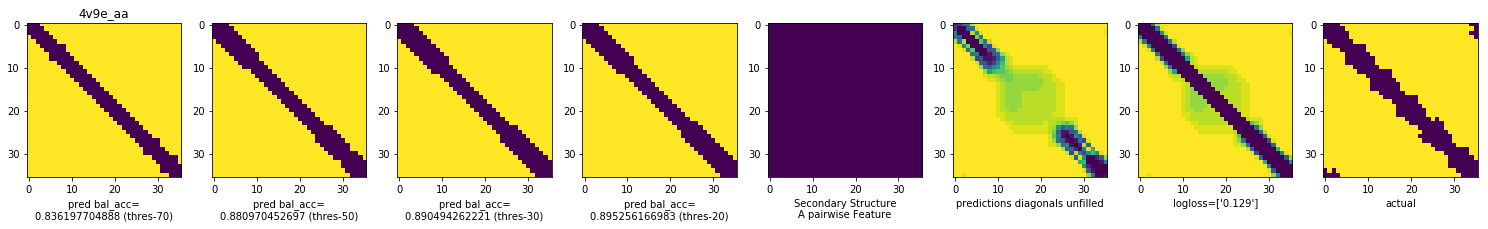

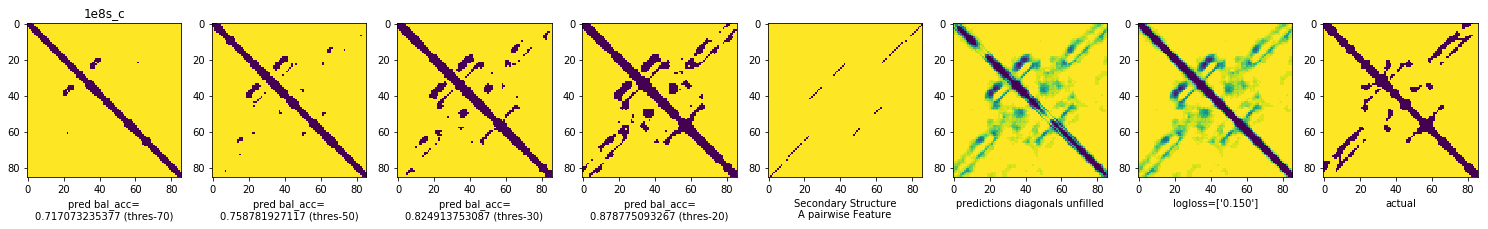

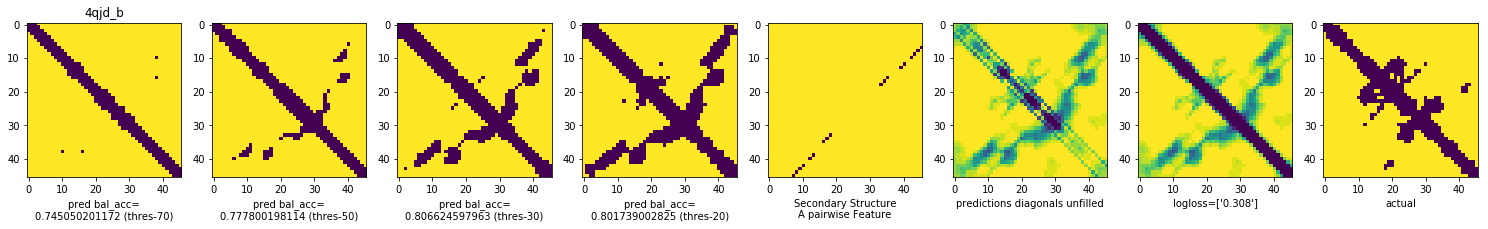

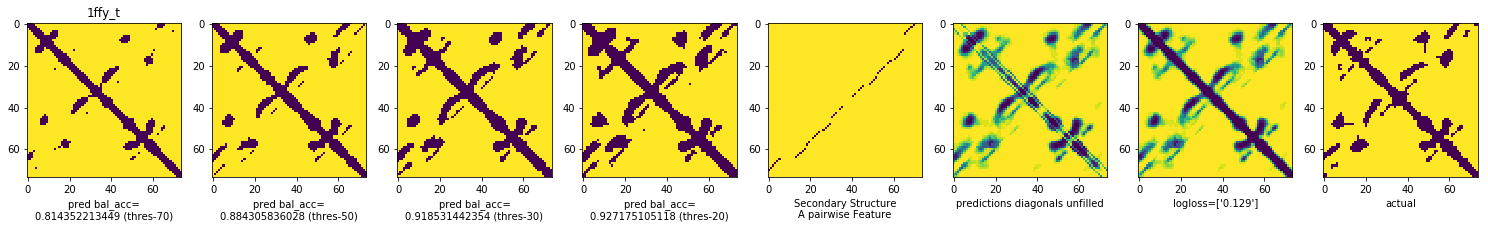

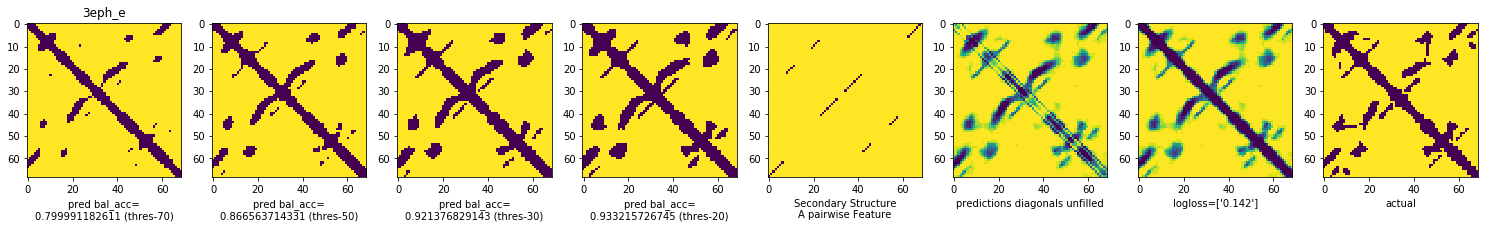

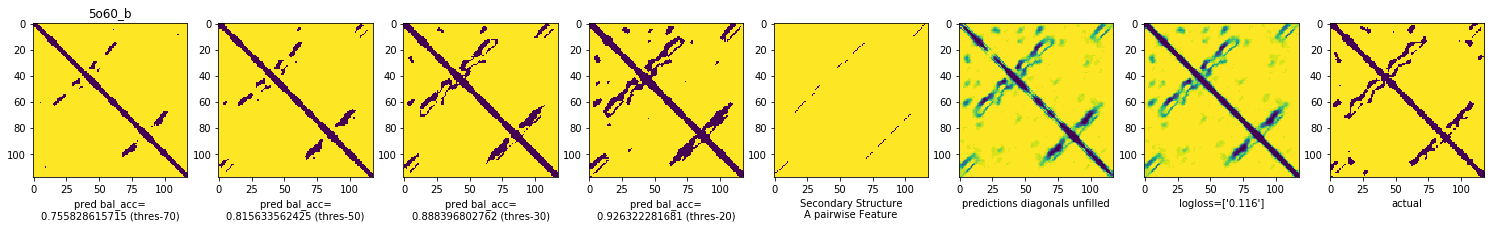

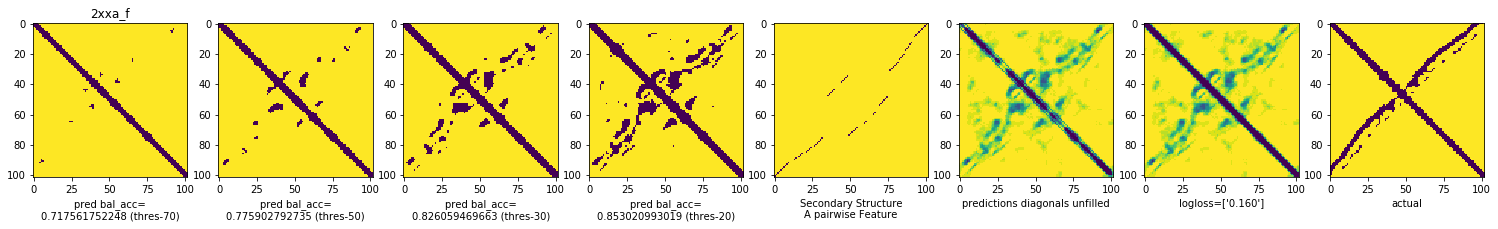

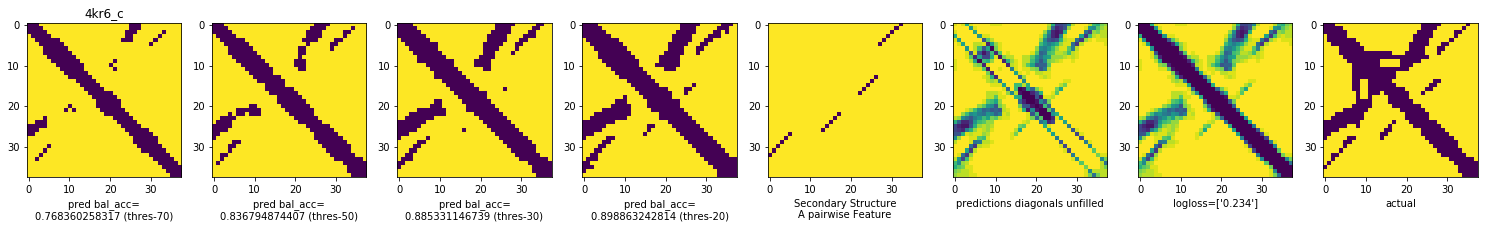

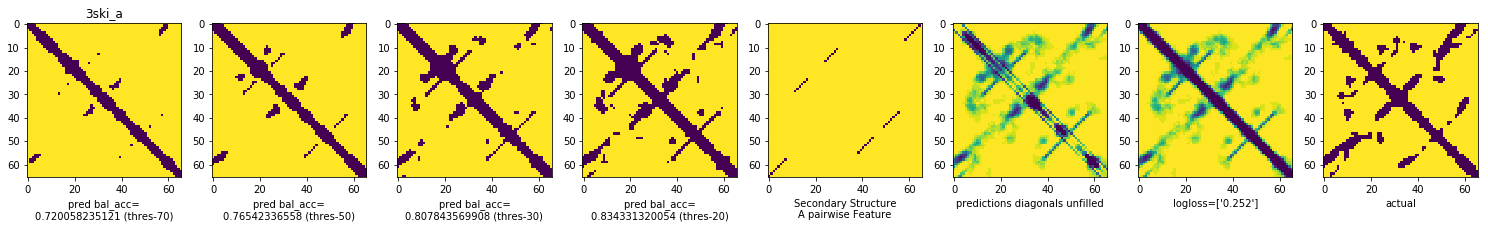

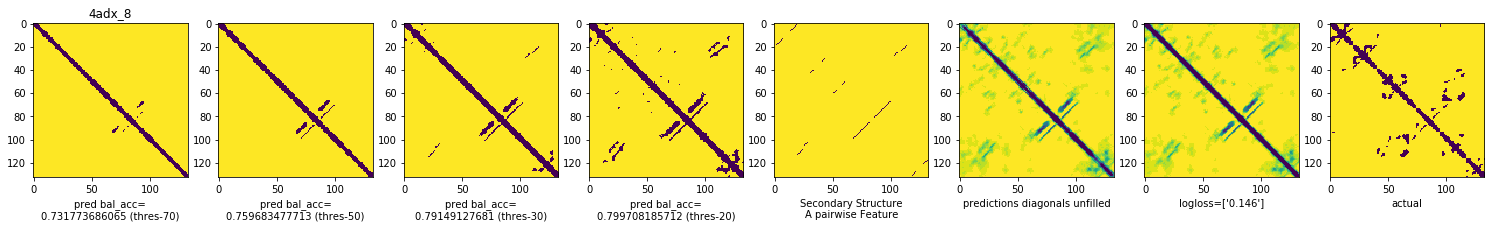

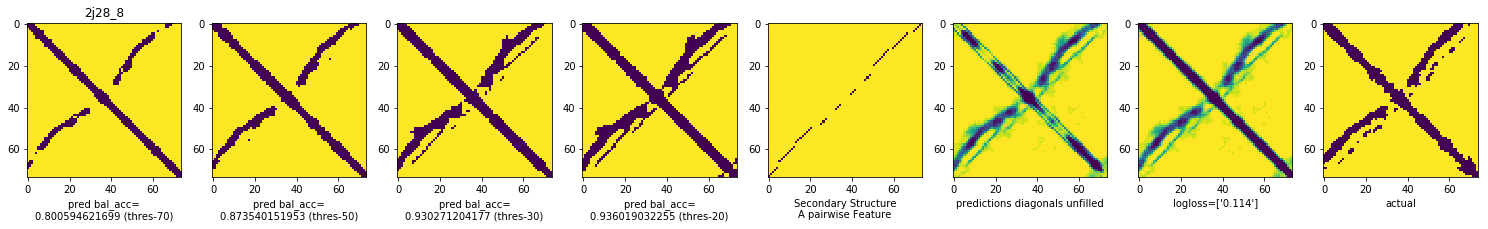

In [52]:
### PLOT VAL RESULTS###
k= 0 
lr = 0
val_acc = []
for i in range(len(data2_x_val))[::10]:
    batch_x, batch_y = np.array([[data2_x_val[i],],]),np.array([data2_y_val[i],])
    batch_y_nan,batch_y_ss = np.array([data2_y_nan_val[i]]),np.array([data2_y_ss_val[i]])
    batch_x = np.swapaxes(np.swapaxes(batch_x,1,3),1,2)
    pred = sess.run( out_softmax, feed_dict={x: batch_x,resi_map0: batch_y,
                                                             above_zero : batch_y_nan, ss_2d : batch_y_ss,
                                                                phase : False, learning_rate : lr, dropout : 0})
    cost_i  = sess.run( cost, feed_dict={x: batch_x,resi_map0: batch_y,
                                                         above_zero : batch_y_nan, ss_2d : batch_y_ss,
                                                         phase : False, learning_rate : lr, dropout : 0})
    temp_pred = pred[k]+np.transpose(pred[k],(1,0,2))
    f, ax = plt.subplots(1,8,figsize=(26,5));k=0
    temp_pred = pred[k]+np.transpose(pred[k],(1,0,2))
    ax[-3].imshow(temp_pred[:,:,0]*200//20)
    temp_pred2 = (temp_pred[:,:,0])*remove_diagonals(1+np.zeros((batch_y_nan.shape[1],batch_y_nan.shape[2])))
    temp_pred[:,:,0] = (temp_pred[:,:,0])*batch_y_nan[0,:,:,0]
    ax[0].imshow(temp_pred2[:,:]>=0.6)
    ax[1].imshow(temp_pred2[:,:]>=1.0)
    ax[2].imshow(temp_pred2[:,:]>=1.4)
    ax[3].imshow(temp_pred2[:,:]>=1.6)
    ax[4].imshow(1-batch_y_ss[0,:,:,0])
    ax[4].set_xlabel('Secondary Structure\nA pairwise Feature')
    ax[-2].imshow(temp_pred[:,:,0] *200//20)
    ax[-1].imshow(batch_y[k,:,:,0]>=1)
    ax[0].set_xlabel('pred bal_acc=\n%s (thres-70)'%accuracy(temp_pred[:,:,0]>=.6,batch_y[k,:,:,0]>=1))
    ax[1].set_xlabel('pred bal_acc=\n%s (thres-50)'%accuracy(temp_pred[:,:,0]>=1.0,batch_y[k,:,:,0]>=1))
    ax[2].set_xlabel('pred bal_acc=\n%s (thres-30)'%accuracy(temp_pred[:,:,0]>=1.4,batch_y[k,:,:,0]>=1))
    ax[3].set_xlabel('pred bal_acc=\n%s (thres-20)'%accuracy(temp_pred[:,:,0]>=1.6,batch_y[k,:,:,0]>=1))
    ax[-2].set_xlabel('logloss=%s' %map(lambda x :str(x)[:5],(cost_i,)))
    ax[-3].set_xlabel('predictions diagonals unfilled')
    ax[-1].set_xlabel('actual')
    ax[0].set_title(data2_name_val[i])
    val_acc += [accuracy(temp_pred[:,:,0]>=1.4,batch_y[k,:,:,0]>=1),]
print ("valiation balanced accuracy %s, " %np.mean(val_acc))
plt.show()

In [28]:
###  TRAIN LOOP, the balanced accuracy here is lower because the diagonals are not predicted correctly being masked out of loss ###
training_epochs = 300
result = {}
random.seed(0)
shuffle = range(len(data2_x))
random.shuffle(shuffle)
text = ''
tf.summary.FileWriter('logs', graph=tf.get_default_graph())
for epoch in range(next_epoch,training_epochs):
    counter = 0
    avg_cost = []
    val_cost = []
    test_cost = []
    train_acc = []
    val_acc = []
    test_acc = []
    total_batch = train_n#int(mnist.train.num_examples/batch_size)
    # Loop over all batches
    shuffle = range(len(data2_x))
    random.shuffle(shuffle)
    num = 1
    if False:
        for batch in range(0,len(shuffle),num):
            batch_list = shuffle[batch:batch+num] #only contains batch of 1. 
            counter += 1
            if epoch %2 == 0:
                lr = 1+np.cos(1.0*batch*3.142/len(shuffle))
            elif epoch %2 == 1:
                lr = 1+np.cos(1.0*batch*3.142/len(shuffle))
            if epoch < training_epochs//2:
                lr = lr/10
            elif epoch < 3*training_epochs//4:
                lr = lr/100
            else:
                lr = lr/1000     
            batch_x = np.array([[data2_x[i]] for i in batch_list])
            batch_y = np.array([data2_y[i]for i in batch_list])
            batch_y_nan = np.array([data2_y_nan[i]  for i in batch_list])
            batch_y_ss = np.array([data2_y_ss[i]  for i in batch_list ])
            batch_x = np.swapaxes(np.swapaxes(batch_x,1,3),1,2)
            if batch_y.shape[1] >= 200:
                continue # prevent RAM problems
            # Run optimization op (backprop) and cost op (to get loss value)
            _, c = sess.run([extra_optimizer, cost], feed_dict={x: batch_x,
                                                          resi_map0: batch_y,
                                                          above_zero : batch_y_nan,
                                                          ss_2d : batch_y_ss,
                                                          phase : True, learning_rate : lr, dropout : 0.0})

    if True:
        k,lr = 0,0
        val_acc = []
        train_acc = []
        avg_cost  = []
        for i in range(0,len(data2_x)):
            batch_x, batch_y = np.array([[data2_x[i],],]),np.array([data2_y[i],])
            batch_y_nan,batch_y_ss = np.array([data2_y_nan[i]]),np.array([data2_y_ss[i]])
            batch_x = np.swapaxes(np.swapaxes(batch_x,1,3),1,2)
            pred = sess.run( out_softmax, feed_dict={x: batch_x,resi_map0: batch_y,
                                                         above_zero : batch_y_nan, ss_2d : batch_y_ss,
                                                            phase : False, learning_rate : lr, dropout : 0})
            c  = sess.run( cost, feed_dict={x: batch_x,resi_map0: batch_y,
                                                         above_zero : batch_y_nan, ss_2d : batch_y_ss,
                                                            phase : False, learning_rate : lr, dropout : 0})
            for k in range(len(batch_y)):
                train_acc += [accuracy((pred[k]+np.transpose(pred[k],(1,0,2)))//1,batch_y[k]),]
            # Compute average loss
            avg_cost += [c,]
        for i in range(len(data2_x_val)):
                batch_x, batch_y = np.array([[data2_x_val[i],],]),np.array([data2_y_val[i],])
                batch_y_nan,batch_y_ss = np.array([data2_y_nan_val[i]]),np.array([data2_y_ss_val[i]])
                batch_x = np.swapaxes(np.swapaxes(batch_x,1,3),1,2)
                cost_i  = sess.run( cost, feed_dict={x: batch_x,resi_map0: batch_y,
                                                     above_zero : batch_y_nan, ss_2d : batch_y_ss,
                                                     phase : False, learning_rate : lr, dropout : 0})
                val_cost += [cost_i,]
                pred =sess.run( out_softmax, feed_dict={x: batch_x,resi_map0: batch_y,
                                                     above_zero : batch_y_nan, ss_2d : batch_y_ss,
                                                        phase : False, learning_rate : lr, dropout : 0})
                val_acc += [accuracy((pred[k]+np.transpose(pred[k],(1,0,2)))//1,batch_y[k]),]                
                if False:
                    temp_pred = pred[k]+np.transpose(pred[k],(1,0,2))
                    f, ax = plt.subplots(1,5,figsize=(19,5));k=0
                    ax[0].imshow(temp_pred[:,:,0]>=1)
                    ax[1].imshow(temp_pred[:,:,0]>=1.2)
                    ax[2].imshow(temp_pred[:,:,0]>=1.4)
                    ax[-2].imshow(temp_pred[:,:,0] *200//20)
                    ax[-1].imshow(batch_y[k,:,:,0]>=1)
                    ax[0].set_xlabel('pred bal_acc=%s (thres-50)'%np.round(accuracy(temp_pred[:,:,0]>=1,batch_y[k,:,:,0]>=1),2))
                    ax[1].set_xlabel('pred bal_acc=%s (thres-40)'%np.round(accuracy(temp_pred[:,:,0]>=1.2,batch_y[k,:,:,0]>=1),2))
                    ax[2].set_xlabel('pred bal_acc=%s (thres-30)'%np.round(accuracy(temp_pred[:,:,0]>=1.4,batch_y[k,:,:,0]>=1),2))
                    ax[-2].set_xlabel('probabilities logloss=%s' %cost_i)
                    ax[-1].set_xlabel('actual')
                    #plt.savefig(   'VAL/'+ data2_name_val[i]+'.png');plt.close()
        test_acc = []
        for i in range(len(data2_x_test)):
                batch_x, batch_y = np.array([[data2_x_test[i],],]),np.array([data2_y_test[i],])
                batch_y_nan,batch_y_ss = np.array([data2_y_nan_test[i]]),np.array([data2_y_ss_test[i]])
                batch_x = np.swapaxes(np.swapaxes(batch_x,1,3),1,2)
                cost_i  = sess.run( cost, feed_dict={x: batch_x,resi_map0: batch_y,
                                                     above_zero : batch_y_nan, ss_2d : batch_y_ss,
                                                     phase : False, learning_rate : lr, dropout : 0})
                test_cost += [cost_i,]
                pred =sess.run( out_softmax, feed_dict={x: batch_x,resi_map0: batch_y,
                                                     above_zero : batch_y_nan, ss_2d : batch_y_ss,
                                                        phase : False, learning_rate : lr, dropout : 0})
                test_acc += [accuracy((pred[k]+np.transpose(pred[k],(1,0,2)))//1,batch_y[k]),]
                if False:
                    temp_pred = pred[k]+np.transpose(pred[k],(1,0,2))
                    f, ax = plt.subplots(1,5,figsize=(19,5));k=0
                    ax[0].imshow(temp_pred[:,:,0]>=1)
                    ax[1].imshow(temp_pred[:,:,0]>=1.2)
                    ax[2].imshow(temp_pred[:,:,0]>=1.4)
                    ax[-2].imshow(temp_pred[:,:,0] *200//20)
                    ax[-1].imshow(batch_y[k,:,:,0]>=1)
                    ax[0].set_xlabel('pred bal_acc=%s (thres-50)'%np.round(accuracy(temp_pred[:,:,0]>=1,batch_y[k,:,:,0]>=1),2))
                    ax[1].set_xlabel('pred bal_acc=%s (thres-40)'%np.round(accuracy(temp_pred[:,:,0]>=1.2,batch_y[k,:,:,0]>=1),2))
                    ax[2].set_xlabel('pred bal_acc=%s (thres-30)'%np.round(accuracy(temp_pred[:,:,0]>=1.4,batch_y[k,:,:,0]>=1),2))
                    ax[-2].set_xlabel('probabilities logloss=%s' %cost_i)
                    ax[-1].set_xlabel('actual')
                    #plt.savefig( data2_name_test[i]+'_%s.png'%thres_distance);plt.close()    # Display logs per epoch step
    f1 = open('updates.log','w')
    text += str(np.mean(avg_cost))+'  '+str(np.mean(train_acc))+'\n'
    text += str(np.mean(val_cost))+'  '+str(np.mean(val_acc))+'\n'
    text += str(np.mean(test_cost))+'  '+str(np.mean(test_acc))+'\n\n'
    print ("Epoch:", '%04d' % (epoch+1), "cost=", 
            "{:.9f}".format(np.mean(avg_cost)),np.mean(train_acc))
    print ("Epoch:", '%04d' % (epoch+1), "cost=", 
            "{:.9f}".format(np.mean(val_cost)),np.mean(val_acc))
    print ("Epoch:", '%04d' % (epoch+1), "cost=", 
            "{:.9f}{}".format(np.mean(val_cost)),np.mean(test_acc))
    f1.write(text)
    f1.close()
    save_path = saver.save(sess,'./model300_reweigh_loss_%s_%s.ckpt' %(epoch,int(100*np.mean(val_acc))))
    result[epoch] = [avg_cost,val_cost]

print ("Optimization Finished!")


KeyboardInterrupt: 

test balanced accuracy 0.801979566128, 


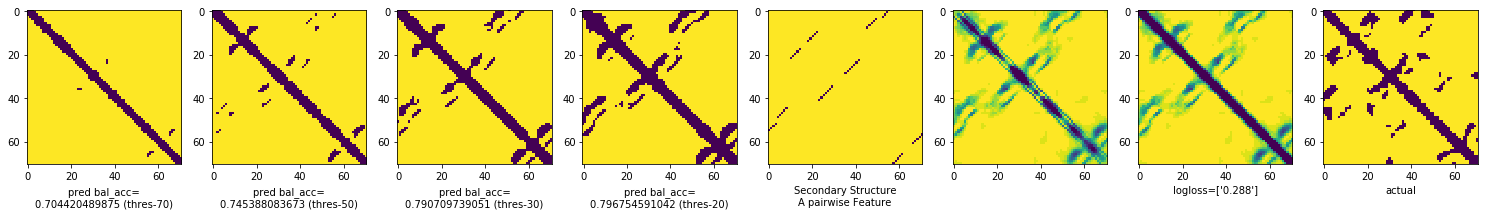

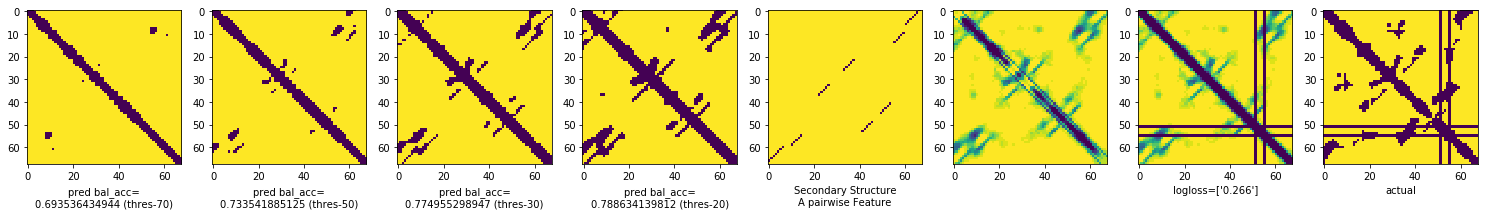

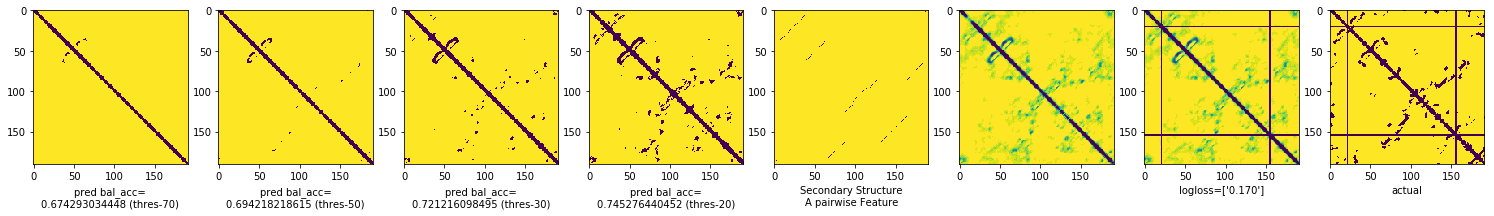

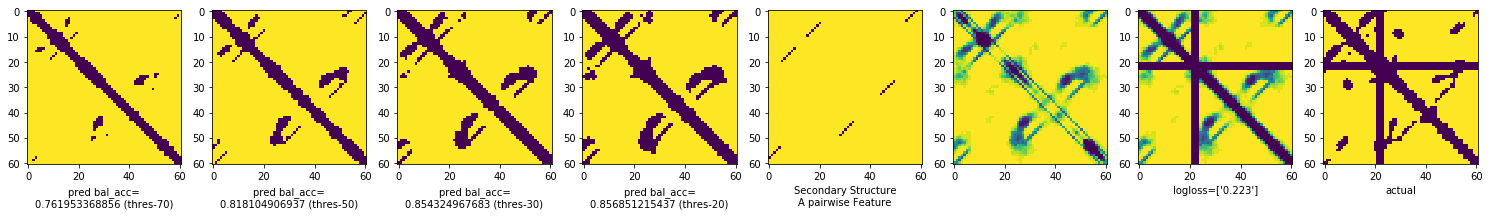

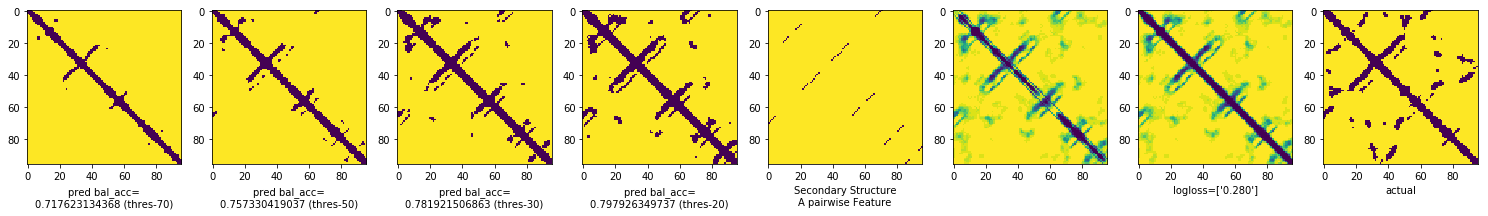

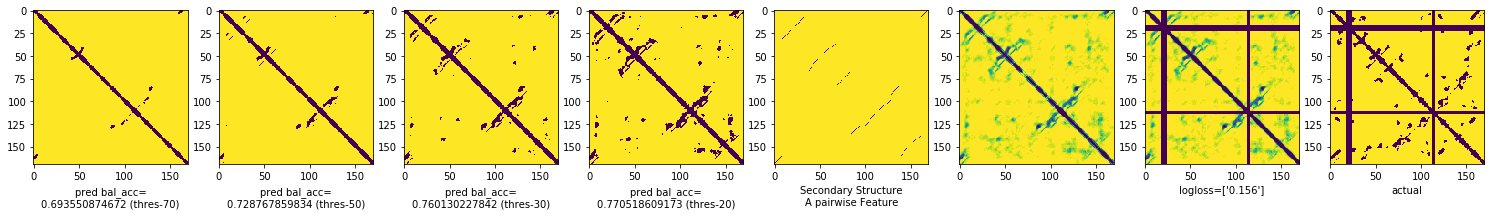

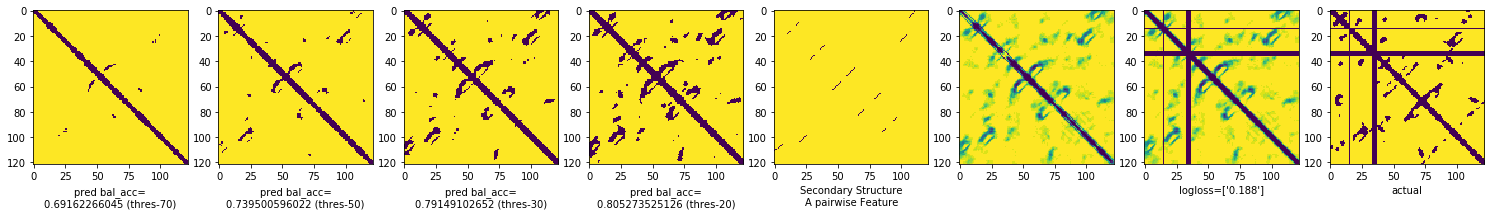

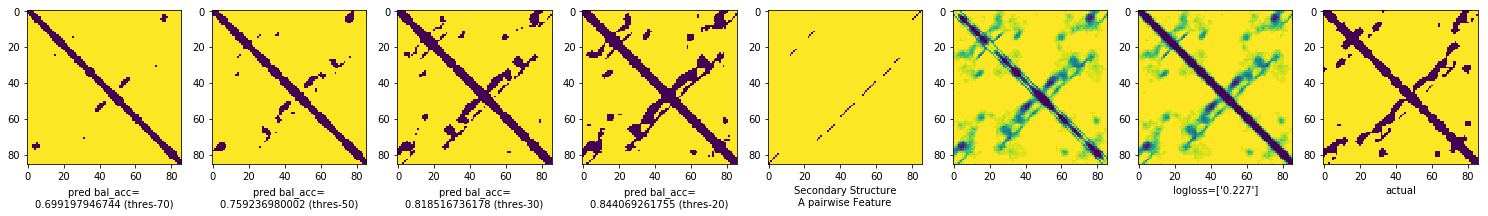

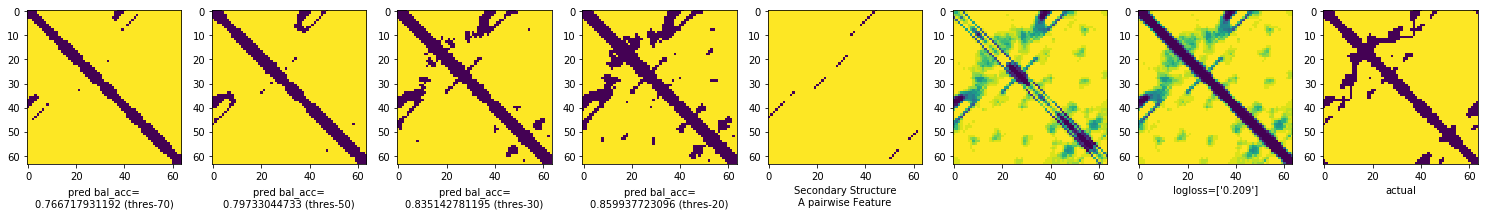

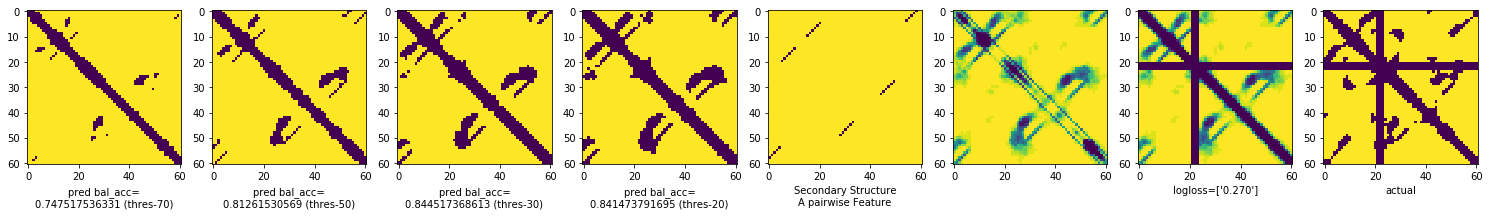

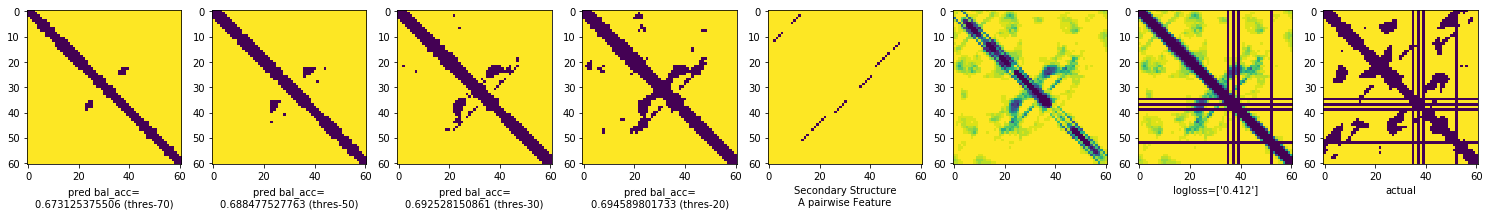

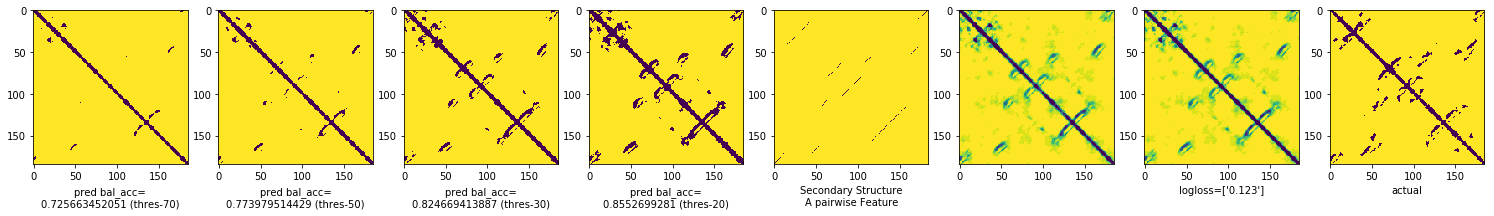

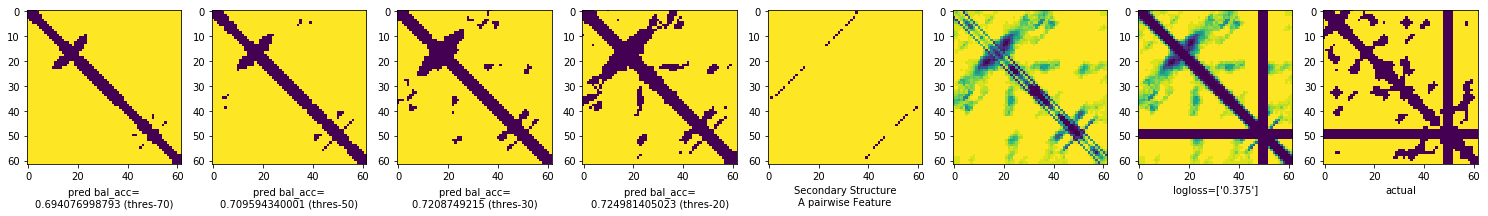

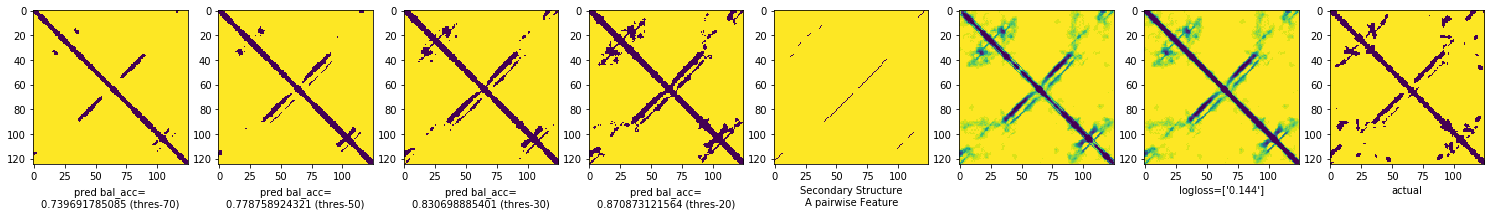

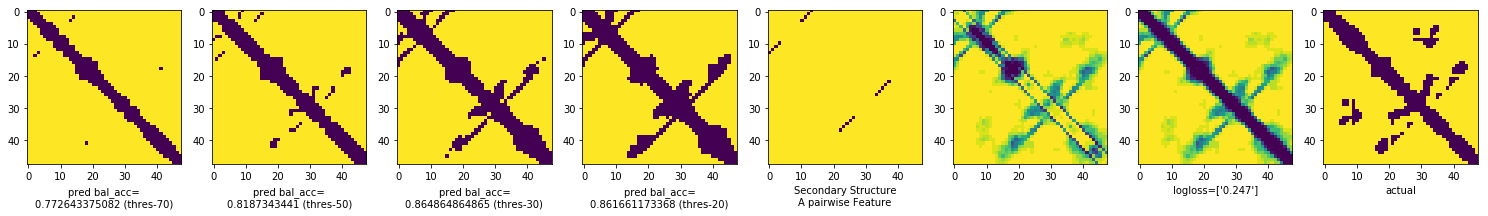

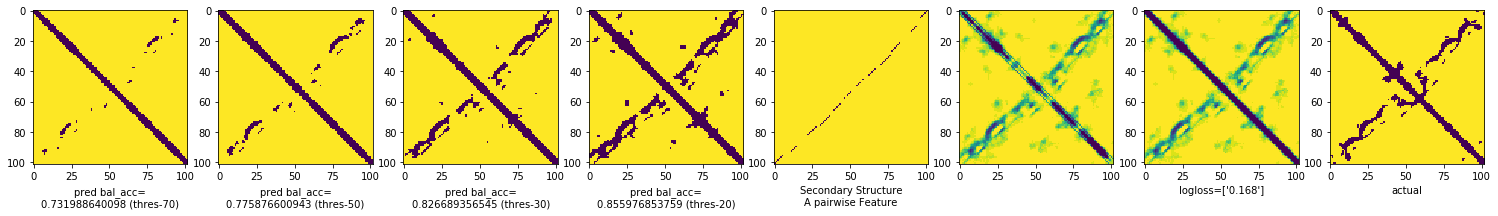

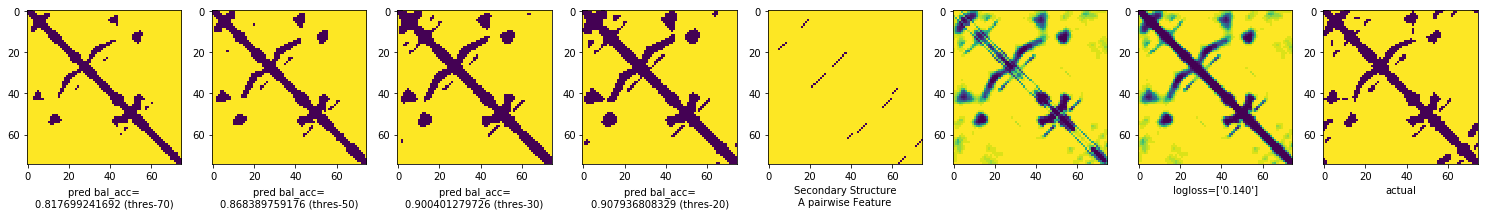

In [47]:
### PLOT TEST RESULTS###
k= 0 
test_acc = []
for i in range(len(data2_x_test)):
    batch_x, batch_y = np.array([[data2_x_test[i],],]),np.array([data2_y_test[i],])
    batch_y_nan,batch_y_ss = np.array([data2_y_nan_test[i]]),np.array([data2_y_ss_test[i]])
    batch_x = np.swapaxes(np.swapaxes(batch_x,1,3),1,2)
    pred = sess.run( out_softmax, feed_dict={x: batch_x,resi_map0: batch_y,
                                                             above_zero : batch_y_nan, ss_2d : batch_y_ss,
                                                                phase : False, learning_rate : lr, dropout : 0})
    cost_i  = sess.run( cost, feed_dict={x: batch_x,resi_map0: batch_y,
                                                         above_zero : batch_y_nan, ss_2d : batch_y_ss,
                                                         phase : False, learning_rate : lr, dropout : 0})
    temp_pred = pred[k]+np.transpose(pred[k],(1,0,2))
    f, ax = plt.subplots(1,8,figsize=(26,5));k=0
    temp_pred = pred[k]+np.transpose(pred[k],(1,0,2))
    ax[-3].imshow(temp_pred[:,:,0]*200//20)
    temp_pred2 = (temp_pred[:,:,0])*remove_diagonals(1+np.zeros((batch_y_nan.shape[1],batch_y_nan.shape[2])))
    temp_pred[:,:,0] = (temp_pred[:,:,0])*batch_y_nan[0,:,:,0]
    ax[0].imshow(temp_pred2[:,:]>=0.6)
    ax[1].imshow(temp_pred2[:,:]>=1.0)
    ax[2].imshow(temp_pred2[:,:]>=1.4)
    ax[3].imshow(temp_pred2[:,:]>=1.6)
    ax[4].imshow(1-batch_y_ss[0,:,:,0])
    ax[4].set_xlabel('Secondary Structure\nA pairwise Feature')
    ax[-2].imshow(temp_pred[:,:,0] *200//20)
    ax[-1].imshow(batch_y[k,:,:,0]>=1)
    ax[0].set_xlabel('pred bal_acc=\n%s (thres-70)'%accuracy(temp_pred[:,:,0]>=.6,batch_y[k,:,:,0]>=1))
    ax[1].set_xlabel('pred bal_acc=\n%s (thres-50)'%accuracy(temp_pred[:,:,0]>=1.0,batch_y[k,:,:,0]>=1))
    ax[2].set_xlabel('pred bal_acc=\n%s (thres-30)'%accuracy(temp_pred[:,:,0]>=1.4,batch_y[k,:,:,0]>=1))
    ax[3].set_xlabel('pred bal_acc=\n%s (thres-20)'%accuracy(temp_pred[:,:,0]>=1.6,batch_y[k,:,:,0]>=1))
    ax[-2].set_xlabel('logloss=%s' %map(lambda x :str(x)[:5],(cost_i,)))
    ax[-1].set_xlabel('actual')
    test_acc += [accuracy(temp_pred[:,:,0]>=1.4,batch_y[k,:,:,0]>=1),]
print ("test balanced accuracy %s, " %np.mean(test_acc))
plt.show()
